In [1]:
import sys
sys.path.append('/u/ajagadish/ermi/functionlearning/')
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import json
import math
import time
import warnings

# Machine learning and statistics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct
import statsmodels.api as sm

# Optimization and curve fitting
from scipy.optimize import curve_fit, OptimizeWarning

# Environment and path management
from os import getenv
from dotenv import load_dotenv

# Other specialized imports
from wordcloud import WordCloud
from collections import Counter
import torch.nn.functional as F
from groupBMC.groupBMC import GroupBMC
FONTSIZE=20
SYS_PATH = '/u/ajagadish/ermi' #'/raven/u/ajagadish/vanilla-llama/'
PARADIGM_PATH = f"{SYS_PATH}/functionlearning"
from plots import plot_functionlearning_data_statistics, proportion_function_types, model_errors_function_types, model_comparison_little2024, model_extrapolation_delosh1997, proportion_function_types_two_modes, interpolation_and_extrapolation_little2024

/u/ajagadish/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


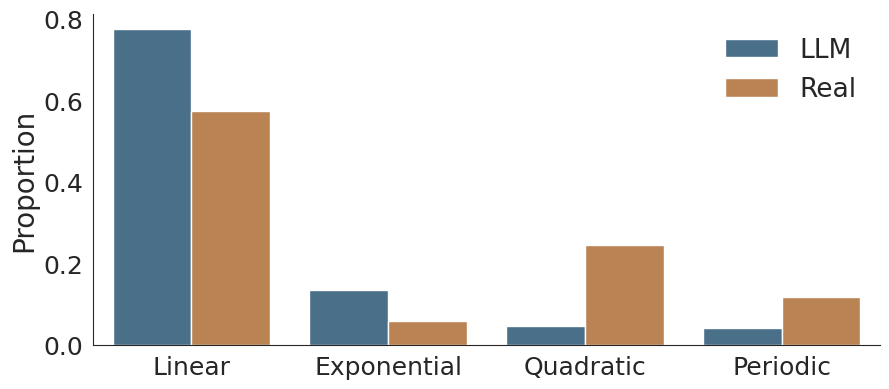

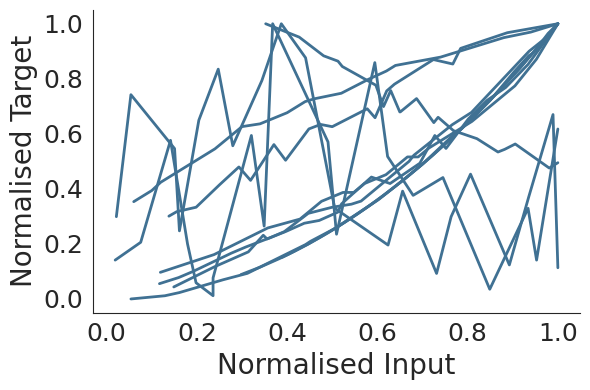

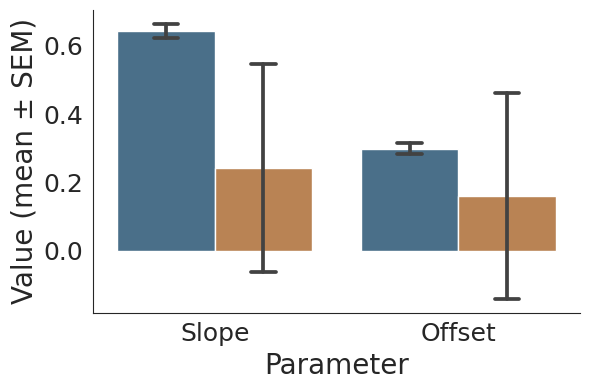

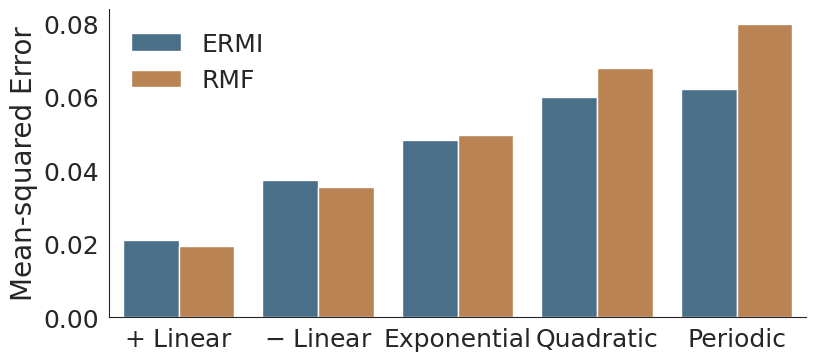

only single


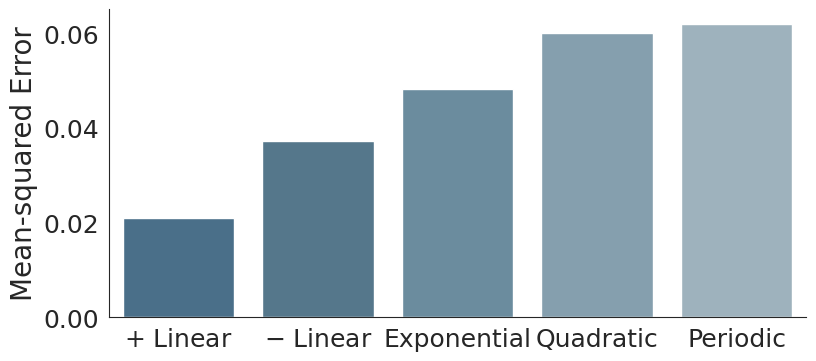

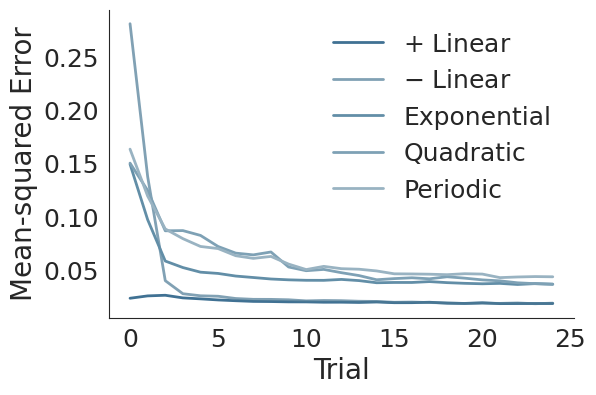

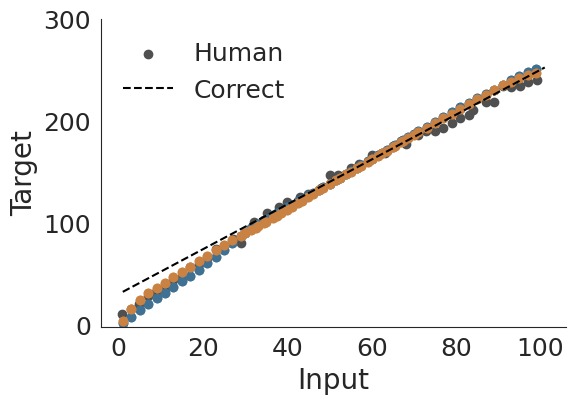

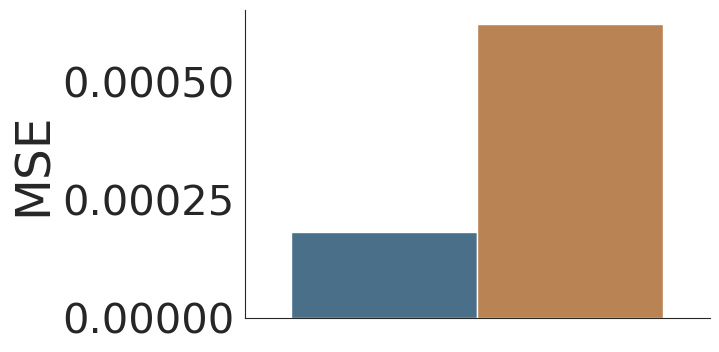

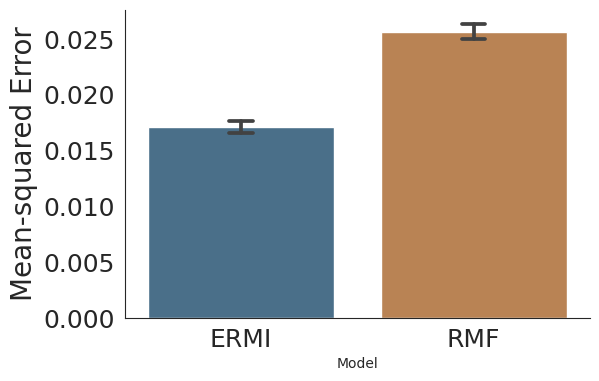

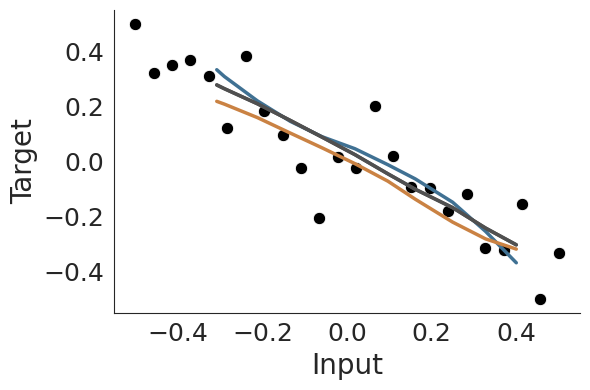

<Figure size 640x480 with 0 Axes>

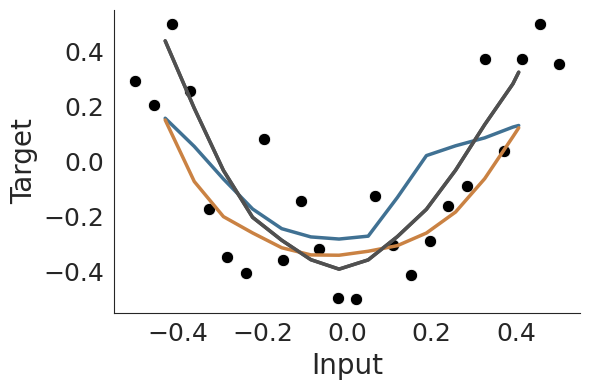

<Figure size 640x480 with 0 Axes>

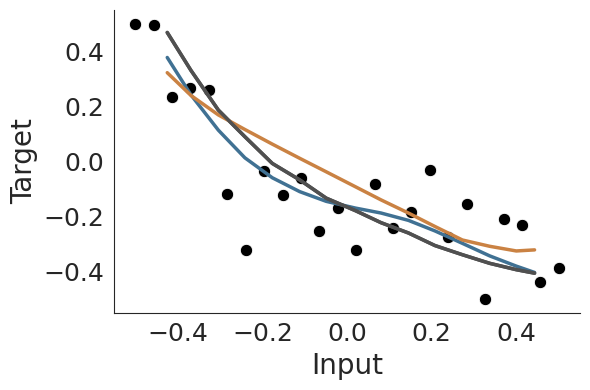

<Figure size 640x480 with 0 Axes>

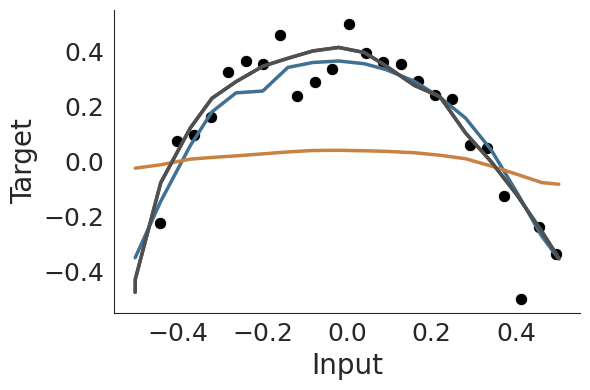

<Figure size 640x480 with 0 Axes>

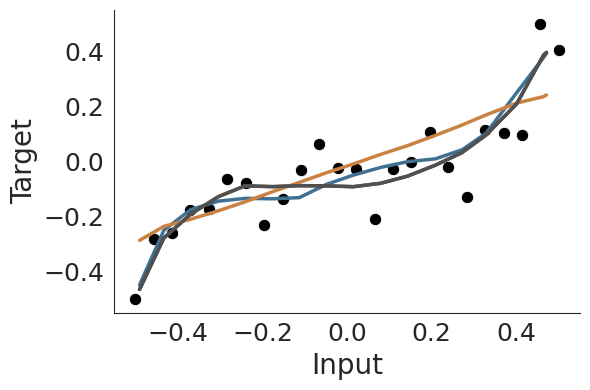

<Figure size 640x480 with 0 Axes>

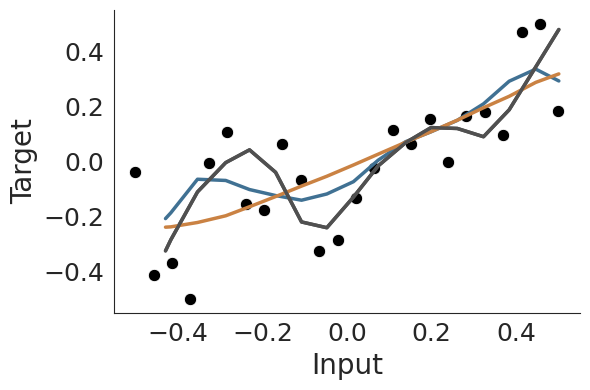

<Figure size 640x480 with 0 Axes>

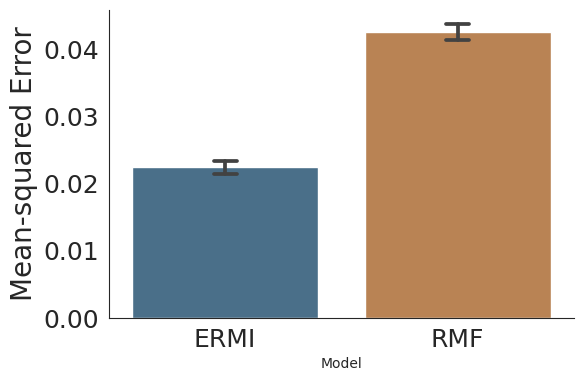

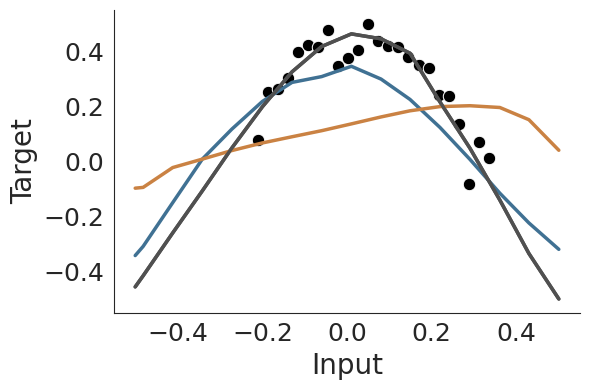

<Figure size 640x480 with 0 Axes>

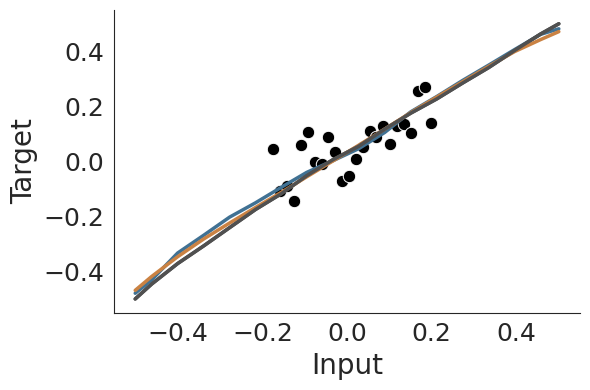

<Figure size 640x480 with 0 Axes>

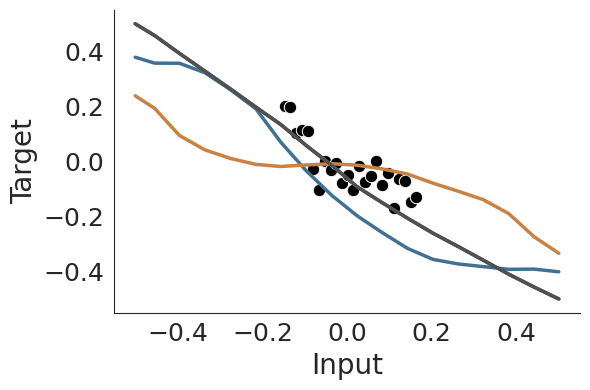

<Figure size 640x480 with 0 Axes>

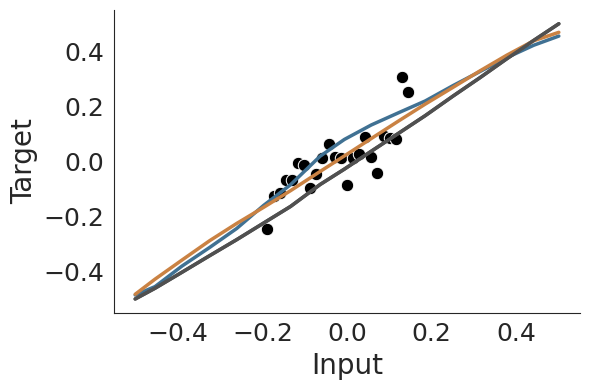

<Figure size 640x480 with 0 Axes>

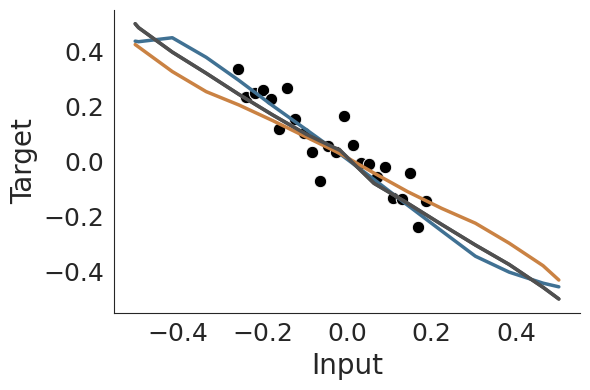

<Figure size 640x480 with 0 Axes>

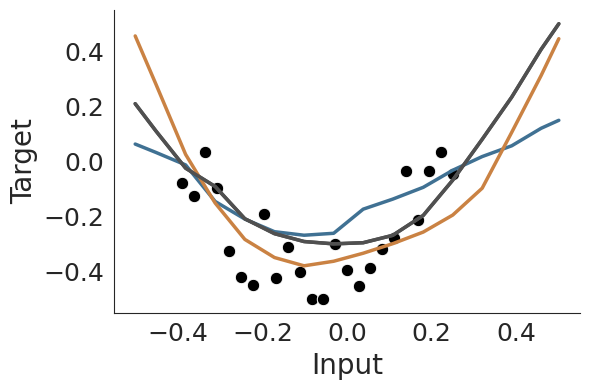

<Figure size 640x480 with 0 Axes>

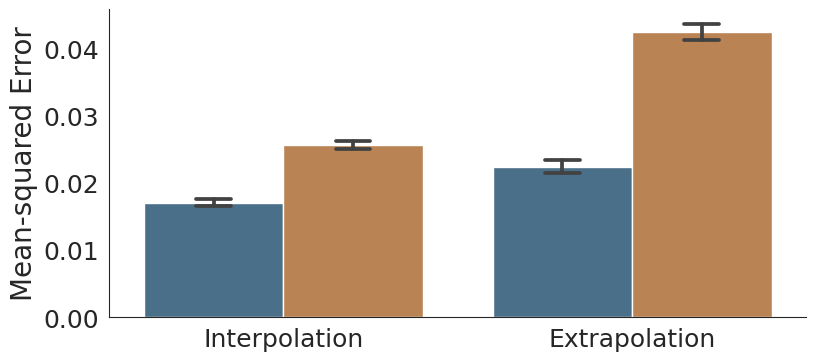

In [3]:
# proportion_function_types(0)
# proportion_function_types(1)
# # proportion_function_types(2)
proportion_function_types_two_modes([0,2])

# # model errors for different function types
model_errors_function_types(model='both')
# # model_errors_function_types(model='mi')
model_errors_function_types(model='ermi')

# model extrapolation
# model_extrapolation_delosh1997(model='ermi')
# model_extrapolation_delosh1997(model='mi')
model_extrapolation_delosh1997(model='both')
# model_extrapolation_delosh1997(model='ermi', offset=True)

# mode comparison
model_comparison_little2024(experiment_id=1)
model_comparison_little2024(experiment_id=3)
interpolation_and_extrapolation_little2024()

# ## results for 6 datapoints (SI)
# model_comparison_little2024(experiment_id=2)
# model_comparison_little2024(experiment_id=4)

In [2]:
def model_extrapolation_delosh1997(model='ermi', FIGSIZE=(6, 4), offset=False, FONTSIZE=20):
    # load model
    if offset:
        results_ermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/env=claude_dim1_maxsteps25_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_kwantes2006.npz')
        results_mi = np.load(f'{PARADIGM_PATH}/data/model_simulation/env=synthetic_dim1_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.01_shuffleTrue_run=0_synthetic_kwantes2006.npz')
    else:
        results_ermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/env=claude_dim1_maxsteps25_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_delosh1997.npz')
        # env=claude_dim1_maxsteps65_model=transformer_num_episodes250000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_ess0.0_run=0_regall_essinit0.0_annealed_schedulefree_dynamic_scaling_delosh1997.npz')
        results_mi = np.load(f'{PARADIGM_PATH}/data/model_simulation/env=synthetic_dim1_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.01_shuffleTrue_run=0_synthetic_delosh1997.npz')
        # env=synthetic_dim1_maxsteps65_dim1_model=transformer_num_episodes250000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.01_shuffleTrue_ess0.0_run=0_synthetic_regall_essinit0.0_annealed_schedulefree_dynamic_scaling_delosh1997.npz')

    # Extract unique functions and calculate MSE for results_ermi
    functions = ['linear_offset'] if offset else ['linear']#, 'exponential', 'quadratic']
    function_names = {'linear': 'Linear', 'exponential': 'Exponential', 'quadratic': 'Quadratic', 'linear_offset': 'Linear with Offset'}
    error_dict_ermi = {'Function': [], 'MSE': [], 'Dataset': [], 'Input': [], 'Target': [], 'Extrapolation_Input': [], 'Extrapolation_Target': [], 'Per_trial_MSE': []}
    error_dict_mi = {'Function': [], 'MSE': [], 'Dataset': [], 'Input': [], 'Target': [], 'Extrapolation_Input': [], 'Extrapolation_Target': [], 'Per_trial_MSE': []}
    for function in functions:
        mse = results_ermi['model_errors'].squeeze()[(results_ermi['ground_truth_functions'] == function)].mean()
        input_data = results_ermi['human_preds'].squeeze()[(results_ermi['ground_truth_functions'] == function)][:, :-1]
        target_data = results_ermi['targets'].squeeze()[(results_ermi['ground_truth_functions'] == function)][:, :-1]
        extrapolation_input = results_ermi['human_preds'].squeeze()[(results_ermi['ground_truth_functions'] == function)][:, -1]
        extrapolation_target = results_ermi['model_preds'].squeeze()[(results_ermi['ground_truth_functions'] == function)][:, -1]
        num_trials = results_ermi['per_trial_model_errors'].shape[-1]
        ground_truth_functions_repeated = np.repeat(results_ermi['ground_truth_functions'][:, :, np.newaxis], num_trials, axis=2).reshape(-1, num_trials)
        per_trial_mse = results_ermi['per_trial_model_errors'].reshape(-1, num_trials)[(ground_truth_functions_repeated == function)].reshape(-1, num_trials)
        error_dict_ermi['Function'].append(function_names[function])
        error_dict_ermi['MSE'].append(mse)
        error_dict_ermi['Dataset'].append('ERMI')
        error_dict_ermi['Input'].append(input_data)
        error_dict_ermi['Target'].append(target_data)
        error_dict_ermi['Extrapolation_Input'].append(extrapolation_input)
        error_dict_ermi['Extrapolation_Target'].append(extrapolation_target)
        error_dict_ermi['Per_trial_MSE'].append(per_trial_mse)
        
        mse = results_mi['model_errors'].squeeze()[(results_mi['ground_truth_functions'] == function)].mean()
        input_data = results_mi['human_preds'].squeeze()[(results_mi['ground_truth_functions'] == function)][:, :-1]
        target_data = results_mi['targets'].squeeze()[(results_mi['ground_truth_functions'] == function)][:, :-1]
        extrapolation_input = results_mi['human_preds'].squeeze()[(results_mi['ground_truth_functions'] == function)][:, -1]
        extrapolation_target = results_mi['model_preds'].squeeze()[(results_mi['ground_truth_functions'] == function)][:, -1]
        per_trial_mse = results_mi['per_trial_model_errors'].reshape(-1, num_trials)[(ground_truth_functions_repeated == function)].reshape(-1, num_trials)
        error_dict_mi['Function'].append(function_names[function])
        error_dict_mi['MSE'].append(mse)
        error_dict_mi['Dataset'].append('RMF')
        error_dict_mi['Input'].append(input_data)
        error_dict_mi['Target'].append(target_data)
        error_dict_mi['Extrapolation_Input'].append(extrapolation_input)
        error_dict_mi['Extrapolation_Target'].append(extrapolation_target)
        error_dict_mi['Per_trial_MSE'].append(per_trial_mse)

    # Combine the data into a single DataFrame
    df_ermi = pd.DataFrame(error_dict_ermi)
    df_mi = pd.DataFrame(error_dict_mi)
    if model == 'ermi':
        df_combined = pd.concat([df_ermi])
    elif model == 'mi':
        df_combined = pd.concat([df_mi])
    else:
        df_combined = pd.concat([df_ermi, df_mi])

    # scatter plot of Input vs Target and Extrapolation Input vs Extrapolation Target for each function
    def linear(x):
        return 2.2 * x + 30
    
    x = np.linspace(1., 101., 100)
    y = linear(x)
    human_data = pd.read_csv(f'{PARADIGM_PATH}/data/human/kwantes2006extrapolation.csv')

    # y = y/250 - 0.5
    # x = x/100 - 0.5
    # sns.set(style="whitegrid")
    if model == 'both':
        fig, axs = plt.subplots(1, 1, figsize=(6, 4))
        axs.scatter(human_data['x'], human_data['y'], label='Human', color='#505050', alpha=1.)
        axs.plot(x, y, label='Correct', color='black', linestyle='--')
        axs.legend(frameon=False, fontsize=FONTSIZE-2)
    for dataset in df_combined['Dataset'].unique():
        for function in df_combined['Function'].unique():
            subset = df_combined[(df_combined['Function'] == function) & (df_combined['Dataset'] == dataset)]
            if model!='both':
                fig, axs = plt.subplots(1, 1, figsize=(6, 4))
            for i, row in subset.iterrows():
                axs.scatter((row['Extrapolation_Input']+0.5)*100, (row['Extrapolation_Target']+0.5)*250, label='', alpha=1.0, color='#407193' if dataset == "ERMI" else '#ca8243')
            axs.set_xlabel('Input', fontsize=FONTSIZE)
            axs.set_ylabel('Target', fontsize=FONTSIZE)
            axs.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
            # add vertical dotted line as a separator at x = -0.5 and x = 0.5
            # axs.axvline(x=-0.25, color='black', linestyle='--', alpha=0.5)
            # axs.axvline(x=0.25, color='black', linestyle='--', alpha=0.5)
            plt.grid(visible=False)
            plt.ylim(-2, 300)
            sns.despine()
            if model!='both':
                axs.plot(x, y, label='Correct', color='black', linestyle='-')
                plt.savefig(f'{SYS_PATH}/figures/functionlearning_extrapolation_function={function}_model={dataset}_offset={str(offset)}.svg', bbox_inches='tight')
            # plt.show()
    axs.legend(frameon=False, fontsize=FONTSIZE-2)
    if model == 'both':
        sns.despine()
        plt.grid(visible=False)
        plt.savefig(f'{SYS_PATH}/figures/functionlearning_extrapolation_function={function}_model={dataset}_offset={str(offset)}.svg', bbox_inches='tight')

    # # Plot the per-trial MSE
    # sns.set(style="whitegrid")
    # for dataset in df_combined['Dataset'].unique():
    #     fig, ax = plt.subplots(figsize=FIGSIZE)
    #     for function in df_combined['Function'].unique():
    #         subset = df_combined[(df_combined['Function'] == function) & (df_combined['Dataset'] == dataset)]
    #         per_trial_mse = np.array(subset['Per_trial_MSE'].values[0])
    #         ax.plot(per_trial_mse.mean(axis=0), label=f'{function}', lw=2)
    #     ax.set_xlabel('Trial', fontsize=FONTSIZE)
    #     ax.set_ylabel('MSE', fontsize=FONTSIZE)
    #     ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
    #     ax.legend(frameon=False, fontsize=FONTSIZE-2)
    #     plt.grid(visible=False)
    #     sns.despine()
    #     plt.show()
    #     plt.savefig(f'{SYS_PATH}/figures/functionlearning_extrapolation_per_trial_mse_function_types_model={dataset}_offset={str(offset)}.svg', bbox_inches='tight')
    
    # Plot the combined data
    if model == 'both':
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.barplot(data=df_combined, x='Function', y='MSE', hue='Dataset', capsize=.1, errorbar="se", ax=ax, palette = ['#407193', '#CA8243'])
        sns.despine()
        ax.legend(frameon=False, fontsize=FONTSIZE-2)
        ax.get_legend().remove()
        ax.set_ylabel('MSE', fontsize=FONTSIZE+15)
        ax.set_xlabel('', fontsize=FONTSIZE)
        ax.set_xticklabels('', fontsize=FONTSIZE)
        ax.tick_params(axis='both', which='major', labelsize=FONTSIZE+10)
        plt.grid(visible=False)
        plt.savefig(f'{SYS_PATH}/figures/functionlearning_extrapolation_mse_function_types_offset={str(offset)}.svg', bbox_inches='tight')
        plt.show()

In [35]:
def proportion_function_types_two_modes(modes=[0, 2], first=True):
    # Collect data for both modes
    all_data = []
    
    for mode in modes:
        # set env_name and color_stats based on mode
        if mode == 0:
            env_name = f'{PARADIGM_PATH}/data/generated_tasks/claude_generated_functionlearningtasks_paramsNA_dim1_data20_tasks9991_run0_procid0_pversion2.csv'
            dataset_name = 'LLM'
        elif mode == 1:  
            env_name = f'{PARADIGM_PATH}/data/generated_tasks/synthetic_functionlearning_tasks_dim1_data25_tasks10000.csv'
            dataset_name = 'Synthetic'
        elif mode == 2: 
            env_name = f'{PARADIGM_PATH}/data/generated_tasks/real_data_dim1_methodbest_lichtenberg2017.csv'
            dataset_name = 'Real'
            
        df = pd.read_csv(env_name)
        first=True
        max_tasks = 1000
        tasks = range(0, max_tasks) if first else np.random.choice(df.task_id.unique(), max_tasks, replace=False)
        df = df[df['task_id'].isin(tasks)]

        # parse single-element list strings
        def parse_val(v):
            try:
                return eval(str(v))[0]
            except:
                return float(str(v).strip("[]"))

        df["input"] = df["input"].apply(parse_val)
        df["target"] = df["target"].apply(parse_val)

        # per-task max-abs normalization
        df["input"] = df.groupby("task_id")["input"].transform(lambda x: x / np.abs(x).max() if x.max()!=0 else x)
        df["target"] = df.groupby("task_id")["target"].transform(lambda x: x / np.abs(x).max() if x.max()!=0 else x)

        # 2. BIC helper
        def bic(sse, n, k):
            if sse <= 0 or n <= k:
                return np.inf
            return k*math.log(n) + n*math.log(sse/n)

        # 3. Model definitions
        def linear_model(x, a, b):
            return a*x + b

        def quadratic_model(x, a, c):
            return a*x**2 + c

        def exponential_model(x, a, b, d):
            return a * np.exp(b*x) + d

        def sine_model(x, a, b, d):
            return a * np.sin(b*x) + d

        # 4. BIC calculators
        def bic_linear(x, y):
            try:
                popt, _ = curve_fit(linear_model, x, y, p0=[1, 0], maxfev=2000)
                sse = ((y - linear_model(x, *popt))**2).sum()
                return bic(sse, len(x), 2), popt
            except:
                return np.inf, (np.nan, np.nan)

        def bic_quadratic(x, y):
            try:
                popt, _ = curve_fit(quadratic_model, x, y, p0=[1, 0], maxfev=2000)
                sse = ((y - quadratic_model(x, *popt))**2).sum()
                return bic(sse, len(x), 2), popt
            except:
                return np.inf, (np.nan, np.nan)

        def bic_exponential(x, y):
            try:
                p0 = [(y.max()-y.min())/2, 1.0, y.min()]
                bounds = ([-np.inf, 0, -np.inf], np.inf)
                popt, _ = curve_fit(exponential_model, x, y, p0=p0, bounds=bounds, maxfev=5000)
                sse = ((y - exponential_model(x, *popt))**2).sum()
                return bic(sse, len(x), 3), popt
            except:
                return np.inf, (np.nan, np.nan, np.nan)

        def bic_periodic(x, y):
            try:
                p0 = [(y.max()-y.min())/2, 2*np.pi, y.mean()]
                bounds = ([-np.inf, 0, -np.inf], np.inf)
                popt, _ = curve_fit(sine_model, x, y, p0=p0, bounds=bounds, maxfev=5000)
                sse = ((y - sine_model(x, *popt))**2).sum()
                return bic(sse, len(x), 3), popt
            except:
                return np.inf, (np.nan, np.nan, np.nan)

        bic_funcs = {
            "linear": bic_linear,
            "quadratic": bic_quadratic,
            "exponential": bic_exponential,
            "periodic": bic_periodic,
        }

        # 5. Evaluate all tasks
        records = []
        linear_coeffs = []
        if os.path.exists(f"{PARADIGM_PATH}/data/stats/fitted_model_params_function_types_{str(mode)}.csv"):
            model_df = pd.read_csv(f"{PARADIGM_PATH}/data/stats/fitted_model_params_function_types_{str(mode)}.csv")
            linear_params = pd.read_csv(f"{PARADIGM_PATH}/data/stats/fitted_linear_model_params_function_types_{str(mode)}.csv")
            records = model_df.values.tolist()
            linear_coeffs = linear_params.values.tolist()
        warnings.filterwarnings("ignore")
        start = time.time()
        if records == [] and linear_coeffs == []:
            for tid, grp in df.groupby("task_id"):
                x = grp["input"].values
                y = grp["target"].values
                if len(x) < 2:
                    continue
                best_bic = np.inf
                best_model = None
                best_params = None
                for name, fn in bic_funcs.items():
                    val, params = fn(x, y)
                    if val < best_bic:
                        best_bic, best_model, best_params = val, name, params
                if best_model is None:
                    continue
                params = tuple(best_params)
                # pad to length 3
                if len(params) < 3:
                    params = params + tuple([np.nan]*(3-len(params)))
                records.append((tid, best_model, best_bic, *params))
                if best_model == "linear":
                    linear_coeffs.append(best_params)

            elapsed = time.time() - start
            print(f"Done: {len(records)} tasks in {elapsed:.1f}s")

            # build DataFrame
            cols = ["task_id", "model", "bic", "p1", "p2", "p3"]
            model_df = pd.DataFrame(records, columns=cols)
            model_df.to_csv(f"{PARADIGM_PATH}/data/stats/fitted_model_params_function_types_{str(mode)}.csv", index=False)
            slopes=np.array([t[0] for t in linear_coeffs if not np.isnan(t[0])])
            offs=np.array([t[1] for t in linear_coeffs if not np.isnan(t[1])])
            slopes = slopes[~np.isnan(slopes)]
            linear_params = pd.DataFrame({"slope": slopes, "offset": offs})
            linear_params.to_csv(f"{PARADIGM_PATH}/data/stats/fitted_linear_model_params_function_types_{str(mode)}.csv", index=False)

        # Store data for this mode
        all_data.append({
            'mode': mode,
            'dataset_name': dataset_name,
            'model_df': model_df,
            'linear_params': linear_params,
            'df': df
        })

    # Settings
    FONTSIZE = 13

    functions = ["linear", "exponential", "quadratic", "periodic"]
    function_names = ["Linear", "Exponential", "Quadratic", "Periodic"]
    
    # Color palettes for each mode using seaborn colors
    color_palettes = {
        0: ['#407193', '#527489', '#63767F', '#747875'],
        1: ['#867A6B', '#A89584', '#CAB0A2', '#ECCBC0'],
        2: ['#CA8243','#B9804D','#A87E57','#8E7B66']
    }

    # Create DataFrame for proportion comparison using seaborn
    proportion_data = []
    for data in all_data:
        props = data['model_df']["model"].value_counts(normalize=True).reindex(functions, fill_value=0)
        for func, prop in props.items():
            proportion_data.append({
                'Function': function_names[functions.index(func)],
                'Proportion': prop,
                'Dataset': data['dataset_name']
            })
    
    proportion_df = pd.DataFrame(proportion_data)
    
    # Create side-by-side bar plot using seaborn
    plt.figure(figsize=(6, 4))
    ax = sns.barplot(data=proportion_df, x='Function', y='Proportion', hue='Dataset', 
                     palette=['#407193', '#CA8243'], alpha=1.0)
    
    # Customize the plot
    ax.set_xlabel('Function Type', fontsize=FONTSIZE)
    ax.set_ylabel('Proportion', fontsize=FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
    
    # Customize legend
    legend = ax.legend(frameon=False, fontsize=FONTSIZE-1)#, title='Dataset')
    # legend.get_frame().set_facecolor('white')
    # legend.get_frame().set_alpha(0.9)
    
    sns.despine()
    plt.tight_layout()
    plt.savefig(f"{SYS_PATH}/figures/proportion_function_types_comparison_seaborn.png", 
                bbox_inches='tight', dpi=300, facecolor='white')
    plt.grid(visible=False)
    plt.show()

    # Create overlay plot with functions from both datasets using seaborn
    plt.figure(figsize=(6, 4))

    n_best = 3
    
    # Prepare data for seaborn line plot
    line_data = []
    
    for func_idx, function in enumerate(functions):
        for data_idx, data in enumerate(all_data):
            mode = data['mode']
            model_df = data['model_df']
            df = data['df']
            
            top = model_df[model_df["model"]==function].nsmallest(n_best, "bic")
            if mode == 0 and function == 'linear':
                top = model_df[model_df["model"]==function][44:47]
            elif mode == 0 and function == 'periodic':
                top = model_df[model_df["model"]==function][8:10]
            elif mode == 0 and function == 'exponential':
                top = model_df[model_df["model"]==function].loc[
                    model_df[model_df["model"]==function]['p2'].sort_values()[-13:-10].index.values]

            for task_idx, tid in enumerate(top["task_id"]):
                g = df[df["task_id"]==tid]
                xs = g["input"].values.astype(float)
                ys = g["target"].values.astype(float)
                ord = np.argsort(xs)
                
                for i in range(len(xs)):
                    line_data.append({
                        'Input': xs[ord][i],
                        'Target': ys[ord][i],
                        'Function_Type': function_names[func_idx],
                        'Dataset': data['dataset_name'],
                        'Task_ID': f"{function}_{data['dataset_name']}_{task_idx}_{tid}"
                    })
    
    line_df = pd.DataFrame(line_data)
    
    # Create the line plot with seaborn
    ax = plt.gca()
    
    # Plot each function type and dataset combination
    function_colors = {
        'Linear': '#407193',
        'Exponential': '#527489', 
        'Quadratic': '#63767F',
        'Periodic': '#747875'
    }
    

    
    for f_idx, func in enumerate(function_names):
        for dataset in ['LLM']:
            subset = line_df[(line_df['Function_Type'] == func) & (line_df['Dataset'] == dataset)]
            if not subset.empty:
                alpha = 0.7 if dataset == 'Real' else 1.0
                linewidth = 2.0 if dataset == 'LLM' else 1.5
                linestyle = '-' if dataset == 'LLM' else '--'
                
                for task_id in subset['Task_ID'].unique():
                    task_data = subset[subset['Task_ID'] == task_id].sort_values('Input')
                    ax.plot(task_data['Input'], task_data['Target'], 
                           color=function_colors['Linear'], alpha=alpha*f_idx/len(function_names), 
                           linewidth=linewidth, linestyle=linestyle)
    
    # Create custom legend
    legend_elements = []
    for func in function_names:
        legend_elements.append(plt.Line2D([0], [0], color=function_colors[func], 
                                        linewidth=2, label=func))
    
    # Add dataset style indicators
    legend_elements.append(plt.Line2D([0], [0], color='gray', linewidth=2, 
                                    linestyle='-', label='LLM'))
    # legend_elements.append(plt.Line2D([0], [0], color='gray', linewidth=1.5, 
    #                                 linestyle='--', alpha=1.0, label='Real'))
    
    # ax.legend(handles=legend_elements, frameon=True, fontsize=FONTSIZE-2, title='Function Type & Dataset', ncol=2)
    
    ax.set_xlabel("Normalised Input", fontsize=FONTSIZE)
    ax.set_ylabel("Normalised Target", fontsize=FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
    plt.grid(visible=False)
    sns.despine()
    plt.tight_layout()
    plt.savefig(f"{SYS_PATH}/figures/top_functions_comparison_seaborn.png", 
                bbox_inches='tight', dpi=300, facecolor='white')
    plt.show()

    # Create linear coefficients comparison using seaborn
    plt.figure(figsize=(6, 4))

    
    # Prepare data for linear coefficients
    coeff_data = []
    for data in all_data:
        linear_params = data['linear_params']
        slopes = linear_params["slope"].values
        offs = linear_params["offset"].values
        
        # Add slope data
        coeff_data.extend([{
            'Parameter': 'Slope',
            'Value': slope,
            'Dataset': data['dataset_name']
        } for slope in slopes])
        
        # Add offset data  
        coeff_data.extend([{
            'Parameter': 'Offset',
            'Value': offset,
            'Dataset': data['dataset_name']
        } for offset in offs])
    
    coeff_df = pd.DataFrame(coeff_data)
    
    # Create the bar plot with error bars using seaborn
    ax = sns.barplot(data=coeff_df, x='Parameter', y='Value', hue='Dataset',
                     palette=['#407193', '#CA8243'], capsize=0.05, 
                     errorbar='se', alpha=1.0)
    
    # Customize the plot
    ax.set_xlabel('Parameter', fontsize=FONTSIZE)
    ax.set_ylabel('Value (mean ± SEM)', fontsize=FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
    
    # Customize legend
    # legend = ax.legend(frameon=False, fontsize=FONTSIZE-1)#, title='Dataset')
    # legend.get_frame().set_facecolor('white')
    # legend.get_frame().set_alpha(0.9)
    ax.get_legend().remove()
    sns.despine()
    plt.grid(visible=False)
    plt.tight_layout()
    plt.savefig(f"{SYS_PATH}/figures/linear_coeffs_comparison_seaborn.png", 
                bbox_inches='tight', dpi=300, facecolor='white')
    plt.show()
    
    # Reset style
    sns.set_style("white")

In [3]:
def model_errors_function_types(model='ermi', FIGSIZE=(6, 4), FONTSIZE=13):
    # Load the data
    results_mi = np.load(f'{PARADIGM_PATH}/data/model_simulation/task=evaluatefunctionlearning_experiment=1_source=synthetic_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
                        #  task=evaluatefunctionlearning_experiment=1_source=synthetic_condition=unknown_loss=nll_paired=False_policy=greedy_ess=0.0.npz')
    results_ermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/task=evaluatefunctionlearning_experiment=1_source=claude_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
                        #    task=evaluatefunctionlearning_experiment=1_source=claude_condition=unknown_loss=nll_paired=False_policy=greedy_ess=0.0.npz')

    # Extract unique functions and calculate MSE for results_ermi
    functions = ['positive_linear', 'negative_linear', 'exponential', 'quadratic', 'sinusoidal']
    if model == 'ermi':
        colors =['#407193', '#4C7994', '#628EA7', '#7EA1B5',  '#99B3C2']
        # colors =['#407193', '#527489', '#63767F', '#747875',  '#867A6B']
    elif model == 'mi':
        # colors = ['#CA8243','#B9804D','#A87E57','#8E7B66', '#747875']
        colors = ['#CA8243','#CD894D','#D59C6A','#E0B590', '#CCA583']
    elif model == 'both':
        colors_ermi =['#407193', '#4C7994', '#628EA7', '#7EA1B5',  '#99B3C2']
        colors_mi = ['#CA8243','#CD894D','#D59C6A','#E0B590', '#CCA583']
    # colors = ['#ca8243', '#B17F52', '#867A6B', '#527489','#407193']
    # colors =['#173b4f', '#173b4f', '#8b9da7', '#5d7684', '#c4d9c2', '#2f4a5a', '#0d2c3d', '#4d6a75', '#748995', '#a2c0a9', '#c4d9c2', '#3b3b3b'][:len(functions)]
    function_names = {'positive_linear': '$\plus$ Linear', 'negative_linear': '$\minus$ Linear', 'quadratic': 'Quadratic', 'exponential': 'Exponential', 'sinusoidal': 'Periodic'}
    error_dict_ermi = {'Function': [], 'MSE': [], 'Dataset': [], 'Per_trial_MSE': []}
    error_dict_mi = {'Function': [], 'MSE': [], 'Dataset': [], 'Per_trial_MSE': []}
    for function in functions:
        mse = results_ermi['model_errors'].squeeze()[(results_ermi['ground_truth_functions'] == function)].mean()
        num_trials = results_ermi['per_trial_model_errors'].shape[-1]
        ground_truth_functions_repeated = np.repeat(results_ermi['ground_truth_functions'][:, :, np.newaxis], num_trials, axis=2).reshape(-1, num_trials)
        per_trial_mse = results_ermi['per_trial_model_errors'].reshape(-1, num_trials)[(ground_truth_functions_repeated == function)].reshape(-1, num_trials)
        error_dict_ermi['Function'].append(function_names[function])
        error_dict_ermi['MSE'].append(mse)
        error_dict_ermi['Dataset'].append('ERMI')
        error_dict_ermi['Per_trial_MSE'].append(per_trial_mse)
        
        mse = results_mi['model_errors'].squeeze()[(results_mi['ground_truth_functions'] == function)].mean()
        ground_truth_functions_repeated = np.repeat(results_mi['ground_truth_functions'][:, :, np.newaxis], num_trials, axis=2).reshape(-1, num_trials)
        per_trial_mse = results_mi['per_trial_model_errors'].reshape(-1, num_trials)[(ground_truth_functions_repeated == function)].reshape(-1, num_trials)
        error_dict_mi['Function'].append(function_names[function])
        error_dict_mi['MSE'].append(mse)
        error_dict_mi['Dataset'].append('RMF')
        error_dict_mi['Per_trial_MSE'].append(per_trial_mse)

    # Combine the data into a single DataFrame
    df_ermi = pd.DataFrame(error_dict_ermi)
    df_mi = pd.DataFrame(error_dict_mi)
    if model == 'ermi':
        df_combined = pd.concat([df_ermi])
    elif model == 'mi':
        df_combined = pd.concat([df_mi])
    else:
        df_combined = pd.concat([df_ermi, df_mi])  

    # Plot the combined data
    fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    if model == 'both':
        # Create side-by-side bars for both datasets using seaborn
        ax = sns.barplot(data=df_combined, x='Function', y='MSE', hue='Dataset', 
                        palette=[colors_ermi[0], colors_mi[0]], alpha=1.0, ax=ax)
        ax.legend(frameon=False, fontsize=FONTSIZE-2)
    else:
        # Single dataset bar plot using seaborn
        # Create a color palette matching the original colors
        palette = colors[:len(df_combined['Function'].unique())]
        ax = sns.barplot(data=df_combined, x='Function', y='MSE', palette=palette, ax=ax)
        ax.tick_params(axis='x', which='major', labelsize=FONTSIZE-2)
    
    sns.despine()
    ax.set_ylabel('Mean-squared Error', fontsize=FONTSIZE)
    # ax.set_xlabel('Function', fontsize=FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
    plt.grid(visible=False)
    plt.savefig(f'{SYS_PATH}/figures/functionlearning_model_error_function_types_{model}.png', bbox_inches='tight')
    plt.show()
    
    if model == 'both':
        print('only single')
    else:
        # Plot the per-trial MSE
        # sns.set(style="whitegrid")
        for dataset in df_combined['Dataset'].unique():
            fig, ax = plt.subplots(figsize=FIGSIZE)
            for f_idx, function in enumerate(df_combined['Function'].unique()):
                subset = df_combined[(df_combined['Function'] == function) & (df_combined['Dataset'] == dataset)]
                per_trial_mse = np.array(subset['Per_trial_MSE'].values[0])
                ax.plot(per_trial_mse.mean(axis=0), label=f'{function}', color=colors[f_idx], alpha=0.7 if f_idx==1 else 1.0, lw=2)
            ax.set_xlabel('Trial', fontsize=FONTSIZE)
            ax.set_ylabel('Mean-squared Error', fontsize=FONTSIZE)
            ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
            ax.legend(frameon=False, fontsize=FONTSIZE-2)
            plt.grid(visible=False)
            sns.despine()
            plt.savefig(f'{SYS_PATH}/figures/functionlearning_per_trial_mse_function_types_{dataset}.png', bbox_inches='tight')
            plt.show()

In [1]:
def model_comparison_little2024(plot_model='together', FIGSIZE=(6,4), experiment_id=1, bermi=False, FONTSIZE=13):
    task_name = 'little2022'
    if bermi:
        rmf = np.load(f'{PARADIGM_PATH}/data/model_simulation/task=little2022_experiment=1_source=synthetic_condition=unknown_loss=nll_paired=False_method=unbounded.npz')
        ermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/task=little2022_experiment=1_source=claude_condition=unknown_loss=nll_paired=False_method=unbounded.npz')
        bermi = np.load(f'{PARADIGM_PATH}/data/model_comparison/task=little2022_experiment=1_source=claude_condition=unknown_loss=nll_paired=False_method=bounded.npz')
        bmi = np.load(f'{PARADIGM_PATH}/data/model_comparison/task=little2022_experiment=1_source=synthetic_condition=unknown_loss=nll_paired=False_method=bounded.npz')
        
        # Convert to long format for seaborn
        all_data = []
        for model_name, values in [('BERMI', bermi['nlls']), ('BMI', bmi['nlls']), 
                                   ('ERMI', ermi['nlls']), ('RMF', rmf['nlls'])]:
            for value in values:
                all_data.append({'Model': model_name, 'MSE': value})
        df = pd.DataFrame(all_data)
    else:
        rmf = np.load(f'{PARADIGM_PATH}/data/model_simulation/task=little2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
        ermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/task=little2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
        
        # Convert to long format for seaborn
        all_data = []
        for model_name, values in [('ERMI', ermi['model_errors'].mean(1).squeeze()), 
                                   ('RMF', rmf['model_errors'].mean(1).squeeze())]:
            for value in values:
                all_data.append({'Model': model_name, 'MSE': value})
        df = pd.DataFrame(all_data)

    fig, ax = plt.subplots(figsize=FIGSIZE)
    sns.barplot(data=df, x='Model', y='MSE', capsize=.1, errorbar="se", ax=ax, 
                palette=['#407193', '#ca8243'] if not bermi else ['#407193', '#ca8243', '#8B7A6B', '#D4A574'])
    sns.despine()
    ax.set_ylabel('Mean-squared Error', fontsize=FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
    plt.grid(visible=False)
    plt.savefig(f'{SYS_PATH}/figures/functionlearning_model_comparison_little2024_expid{experiment_id}.png', bbox_inches='tight')
    plt.show()
    
    if bermi:
        bermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/task={task_name}_experiment=1_source=claude_condition=unknown_loss=nll_paired=False_policy=greedy_ess={str(bermi["ess"][np.argmin(bermi["nlls"])])}.npz')
        bmi = np.load(f'{PARADIGM_PATH}/data/model_simulation/task={task_name}_experiment=1_source=synthetic_condition=unknown_loss=nll_paired=False_policy=greedy_ess={str(bmi["ess"][np.argmin(bmi["nlls"])])}.npz')
        ermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/task={task_name}_experiment=1_source=claude_condition=unknown_loss=nll_paired=False_policy=greedy_ess=0.0.npz')
        rmf = np.load(f'{PARADIGM_PATH}/data/model_simulation/task={task_name}_experiment=1_source=synthetic_condition=unknown_loss=nll_paired=False_policy=greedy_ess=0.0.npz')   
        models = [bermi, bmi, ermi, rmf]
        subjects = [np.argmin(bermi['nlls']), np.argmin(bmi['nlls']), np.argmin(ermi['model_errors'].mean(1).squeeze()), np.argmin(rmf['model_errors'].mean(1).squeeze())]
        model_names = ['BERMI', 'BMI', 'ERMI', 'RMF']
        colors = ['#8B7A6B', '#D4A574', '#407193', '#ca8243']
    else:
        models = [ermi, rmf] 
        subjects = [np.argmin(ermi['model_errors'].mean(1).squeeze()), np.argmin(ermi['model_errors'].mean(1).squeeze())]
        model_names = ['ERMI', 'RMF']
        colors = ['#407193', '#ca8243']

    num_functions = models[0]['human_preds'].shape[1]
    num_participants = models[0]['model_preds'].shape[0]
    num_data = 20 if experiment_id == 1 or experiment_id == 3 else 5

    # Create separate plots for each model and each function using seabor
    for function in range(num_functions):
        # Set up the plot with seaborn style
        fig, ax = plt.subplots(figsize=FIGSIZE)
        # sns.set_style("whitegrid")
        for model_idx, (subject, model, model_name, color) in enumerate(zip(subjects, models, model_names, colors)):
            ref = rmf if model_name == 'RMF' else ermi if model_name == 'ERMI' else bmi if model_name == 'BMI' else bermi

            # Prepare data for seaborn
            x_vals = model['human_preds'][subject, function, :, 0]
            y_model = model['model_preds'].reshape(num_participants, num_functions, num_data)[subject, function]
            y_human = ref['human_preds'][subject, function, :, 1]
            x_gt = ref['ground_truth_functions'][subject, function, :, 0]
            y_gt = ref['ground_truth_functions'][subject, function, :, 1]

            # Create DataFrame for seaborn plotting
            plot_data = pd.DataFrame({
                'Input': np.concatenate([x_vals, x_vals, x_gt]),
                'Target': np.concatenate([y_model, y_human, y_gt]),
                'Type': ['Model'] * len(x_vals) + ['Human'] * len(x_vals) + ['Ground Truth'] * len(x_gt)
            })

            # Plot model predictions
            sns.lineplot(data=plot_data[plot_data['Type'] == 'Model'], 
                        x='Input', y='Target', 
                        color=color, linewidth=2.5, label=model_name, ax=ax)

            # Plot human predictions
            sns.lineplot(data=plot_data[plot_data['Type'] == 'Human'], 
                        x='Input', y='Target', 
                        color='#505050', linewidth=2.5, label='Human', ax=ax)

            # Plot ground truth as scatter
            sns.scatterplot(data=plot_data[plot_data['Type'] == 'Ground Truth'], 
                           x='Input', y='Target', 
                           color='black', s=80, label='Ground Truth', ax=ax)

        # Customize the plot
        ax.set_xlabel('Input', fontsize=FONTSIZE)
        ax.set_ylabel('Target', fontsize=FONTSIZE)
        # ax.set_title(f'{model_name} - Function {function + 1}', fontsize=FONTSIZE + 2, pad=20)
        ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)

        # # Customize legend
        # legend = ax.legend(frameon=True, fontsize=FONTSIZE-2, loc='best')
        # legend.get_frame().set_facecolor('white')
        # legend.get_frame().set_alpha(0.9)
        # legend.get_frame().set_edgecolor('gray')
        # legend.get_frame().set_linewidth(0.5)

        # Remove grid for cleaner look
        ax.grid(False)
        ax.get_legend().remove()

        # Use seaborn despine for cleaner axes
        sns.despine(ax=ax)

        # Adjust layout and save
        plt.tight_layout()
        plt.savefig(f'{SYS_PATH}/figures/functionlearning_model_comparison_little2024_function{function}_model{model_name}_expid{experiment_id}_seaborn.png', 
                   bbox_inches='tight', dpi=300, facecolor='white')
        plt.show()

        # Clear the current figure to avoid memory issues
        plt.clf()

In [10]:
def model_comparison_little2024(plot_model='together', FIGSIZE=(6,4), experiment_id=1, bermi=False, FONTSIZE=13):
    task_name = 'little2022'
    if bermi:
        rmf = np.load(f'{PARADIGM_PATH}/data/model_simulation/task=little2022_experiment=1_source=synthetic_condition=unknown_loss=nll_paired=False_method=unbounded.npz')
        ermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/task=little2022_experiment=1_source=claude_condition=unknown_loss=nll_paired=False_method=unbounded.npz')
        bermi = np.load(f'{PARADIGM_PATH}/data/model_comparison/task=little2022_experiment=1_source=claude_condition=unknown_loss=nll_paired=False_method=bounded.npz')
        bmi = np.load(f'{PARADIGM_PATH}/data/model_comparison/task=little2022_experiment=1_source=synthetic_condition=unknown_loss=nll_paired=False_method=bounded.npz')
        
        # Convert to long format for seaborn
        all_data = []
        for model_name, values in [('BERMI', bermi['nlls']), ('BMI', bmi['nlls']), 
                                   ('ERMI', ermi['nlls']), ('RMF', rmf['nlls'])]:
            for value in values:
                all_data.append({'Model': model_name, 'MSE': value})
        df = pd.DataFrame(all_data)
    else:
        rmf = np.load(f'{PARADIGM_PATH}/data/model_simulation/task=little2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
        ermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/task=little2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
        
        # Convert to long format for seaborn
        all_data = []
        for model_name, values in [('ERMI', ermi['model_errors'].mean(1).squeeze()), 
                                   ('RMF', rmf['model_errors'].mean(1).squeeze())]:
            for value in values:
                all_data.append({'Model': model_name, 'MSE': value})
        df = pd.DataFrame(all_data)

    fig, ax = plt.subplots(figsize=FIGSIZE)
    sns.barplot(data=df, x='Model', y='MSE', capsize=.1, errorbar="se", ax=ax, 
                palette=['#407193', '#ca8243'] if not bermi else ['#407193', '#ca8243', '#8B7A6B', '#D4A574'])
    sns.despine()
    ax.set_ylabel('Mean-squared Error', fontsize=FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
    plt.grid(visible=False)
    plt.savefig(f'{SYS_PATH}/figures/functionlearning_model_comparison_little2024_expid{experiment_id}.png', bbox_inches='tight')
    plt.show()
    
    if bermi:
        bermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/task={task_name}_experiment=1_source=claude_condition=unknown_loss=nll_paired=False_policy=greedy_ess={str(bermi["ess"][np.argmin(bermi["nlls"])])}.npz')
        bmi = np.load(f'{PARADIGM_PATH}/data/model_simulation/task={task_name}_experiment=1_source=synthetic_condition=unknown_loss=nll_paired=False_policy=greedy_ess={str(bmi["ess"][np.argmin(bmi["nlls"])])}.npz')
        ermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/task={task_name}_experiment=1_source=claude_condition=unknown_loss=nll_paired=False_policy=greedy_ess=0.0.npz')
        rmf = np.load(f'{PARADIGM_PATH}/data/model_simulation/task={task_name}_experiment=1_source=synthetic_condition=unknown_loss=nll_paired=False_policy=greedy_ess=0.0.npz')   
        models = [bermi, bmi, ermi, rmf]
        subjects = [np.argmin(bermi['nlls']), np.argmin(bmi['nlls']), np.argmin(ermi['model_errors'].mean(1).squeeze()), np.argmin(rmf['model_errors'].mean(1).squeeze())]
        model_names = ['BERMI', 'BMI', 'ERMI', 'RMF']
        colors = ['#8B7A6B', '#D4A574', '#407193', '#ca8243']
    else:
        models = [ermi, rmf] 
        subjects = [np.argmin(ermi['model_errors'].mean(1).squeeze()), np.argmin(ermi['model_errors'].mean(1).squeeze())]
        model_names = ['ERMI', 'RMF']
        colors = ['#407193', '#ca8243']

    num_functions = models[0]['human_preds'].shape[1]
    num_participants = models[0]['model_preds'].shape[0]
    num_data = 20 if experiment_id == 1 or experiment_id == 3 else 5
    
    if plot_model=='together':
        _, axs = plt.subplots(1, num_functions, figsize=(6*num_functions, 4))
    
    for first, (subject, model, model_name, color) in enumerate(zip(subjects, models, model_names, colors)):
        ref = rmf if model_name == 'RMF' else ermi if model_name == 'ERMI' else bmi if model_name == 'BMI' else bermi
        if plot_model == 'separate':
            _, axs = plt.subplots(1, num_functions, figsize=(6*num_functions, 4))
        
        for function in range(num_functions):
            axs[function].plot(model['human_preds'][subject, function, :, 0], 
                             model['model_preds'].reshape(num_participants, num_functions, num_data)[subject, function], 
                             lw=2, label=model_name, color=color)
            
            if first == 0 and plot_model == 'together':
                axs[function].scatter(ref['ground_truth_functions'][subject, function, :, 0], 
                                    ref['ground_truth_functions'][subject, function, :, 1], 
                                    c='black', label="Ground Truth")
                axs[function].plot(ref['human_preds'][subject, function, :, 0], 
                                 ref['human_preds'][subject, function, :, 1], 
                                 c='#505050', lw=2, label='Human')
            elif plot_model == 'separate':
                axs[function].scatter(ref['ground_truth_functions'][subject, function, :, 0], 
                                    ref['ground_truth_functions'][subject, function, :, 1], 
                                    c='black', label="Ground Truth")
                axs[function].plot(ref['human_preds'][subject, function, :, 0], 
                                 ref['human_preds'][subject, function, :, 1], 
                                 c='#505050', lw=2, label='Human')
                
            axs[function].grid(visible=False)
            axs[function].set_xlabel('Input', fontsize=FONTSIZE)
            axs[function].set_ylabel('Target', fontsize=FONTSIZE)
            axs[function].legend(frameon=False, fontsize=FONTSIZE-4)
            
        if plot_model == 'separate':
            for ax in axs:
                ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
            sns.despine()
            plt.tight_layout()
            plt.savefig(f'{SYS_PATH}/figures/functionlearning_model_comparison_little2024_functions_subject{subject}_model{model_name}_expid{experiment_id}.png', bbox_inches='tight')
            plt.show()
            
    if plot_model == 'together':
        for ax in axs:
            ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
        sns.despine()
        plt.tight_layout()
        plt.savefig(f'{SYS_PATH}/figures/functionlearning_model_comparison_little2024_functions_combined_expid{experiment_id}.png', bbox_inches='tight')
        plt.show()

In [3]:
def interpolation_and_extrapolation_little2024(FIGSIZE=(6,4), experiment_ids=[1,3], FONTSIZE=13):
    # Collect data for both experiments
    all_data = []
    
    for experiment_id in experiment_ids:
        rmf = np.load(f'{PARADIGM_PATH}/data/model_simulation/task=little2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
        ermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/task=little2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
        
        # Create DataFrame in long format for seaborn
        ermi_errors = ermi['model_errors'].mean(1).squeeze()
        rmf_errors = rmf['model_errors'].mean(1).squeeze()
        
        experiment_name = 'Interpolation' if experiment_id == 1 else 'Extrapolation'
        
        # Add ERMI data
        for error in ermi_errors:
            all_data.append({
                'Experiment': experiment_name,
                'Model': 'ERMI',
                'MSE': error
            })
        
        # Add RMF data  
        for error in rmf_errors:
            all_data.append({
                'Experiment': experiment_name,
                'Model': 'RMF', 
                'MSE': error
            })
    
    df_combined = pd.DataFrame(all_data)
    
    fig, ax = plt.subplots(figsize=FIGSIZE)
    sns.barplot(data=df_combined, x='Experiment', y='MSE', hue='Model', 
                capsize=.1, errorbar="se", ax=ax, palette=['#ca8243', '#407193'])
    
    sns.despine()
    ax.set_ylabel('Mean-squared Error', fontsize=FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
    ax.legend(frameon=False, fontsize=FONTSIZE-2)
    plt.grid(visible=False)
    plt.savefig(f'{SYS_PATH}/figures/functionlearning_model_comparison_little2024_combined.png', bbox_inches='tight')
    plt.show()

In [61]:
def model_extrapolation_delosh1997(model='ermi', FIGSIZE=(6, 4), offset=False, FONTSIZE=13):
    # load model
    if offset:
        results_ermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/env=claude_dim1_maxsteps25_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_kwantes2006.npz')
        results_mi = np.load(f'{PARADIGM_PATH}/data/model_simulation/env=synthetic_dim1_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.01_shuffleTrue_run=0_synthetic_kwantes2006.npz')
    else:
        results_ermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/env=claude_dim1_maxsteps25_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_delosh1997.npz')
        # env=claude_dim1_maxsteps65_model=transformer_num_episodes250000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_ess0.0_run=0_regall_essinit0.0_annealed_schedulefree_dynamic_scaling_delosh1997.npz')
        results_mi = np.load(f'{PARADIGM_PATH}/data/model_simulation/env=synthetic_dim1_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.01_shuffleTrue_run=0_synthetic_delosh1997.npz')
        # env=synthetic_dim1_maxsteps65_dim1_model=transformer_num_episodes250000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.01_shuffleTrue_ess0.0_run=0_synthetic_regall_essinit0.0_annealed_schedulefree_dynamic_scaling_delosh1997.npz')

    # Extract unique functions and calculate MSE for results_ermi
    functions = ['linear_offset'] if offset else ['linear']#, 'exponential', 'quadratic']
    function_names = {'linear': 'Linear', 'exponential': 'Exponential', 'quadratic': 'Quadratic', 'linear_offset': 'Linear with Offset'}
    error_dict_ermi = {'Function': [], 'MSE': [], 'Dataset': [], 'Input': [], 'Target': [], 'Extrapolation_Input': [], 'Extrapolation_Target': [], 'Per_trial_MSE': []}
    error_dict_mi = {'Function': [], 'MSE': [], 'Dataset': [], 'Input': [], 'Target': [], 'Extrapolation_Input': [], 'Extrapolation_Target': [], 'Per_trial_MSE': []}
    for function in functions:
        mse = results_ermi['model_errors'].squeeze()[(results_ermi['ground_truth_functions'] == function)].mean()
        input_data = results_ermi['human_preds'].squeeze()[(results_ermi['ground_truth_functions'] == function)][:, :-1]
        target_data = results_ermi['targets'].squeeze()[(results_ermi['ground_truth_functions'] == function)][:, :-1]
        extrapolation_input = results_ermi['human_preds'].squeeze()[(results_ermi['ground_truth_functions'] == function)][:, -1]
        extrapolation_target = results_ermi['model_preds'].squeeze()[(results_ermi['ground_truth_functions'] == function)][:, -1]
        num_trials = results_ermi['per_trial_model_errors'].shape[-1]
        ground_truth_functions_repeated = np.repeat(results_ermi['ground_truth_functions'][:, :, np.newaxis], num_trials, axis=2).reshape(-1, num_trials)
        per_trial_mse = results_ermi['per_trial_model_errors'].reshape(-1, num_trials)[(ground_truth_functions_repeated == function)].reshape(-1, num_trials)
        error_dict_ermi['Function'].append(function_names[function])
        error_dict_ermi['MSE'].append(mse)
        error_dict_ermi['Dataset'].append('ERMI')
        error_dict_ermi['Input'].append(input_data)
        error_dict_ermi['Target'].append(target_data)
        error_dict_ermi['Extrapolation_Input'].append(extrapolation_input)
        error_dict_ermi['Extrapolation_Target'].append(extrapolation_target)
        error_dict_ermi['Per_trial_MSE'].append(per_trial_mse)
        
        mse = results_mi['model_errors'].squeeze()[(results_mi['ground_truth_functions'] == function)].mean()
        input_data = results_mi['human_preds'].squeeze()[(results_mi['ground_truth_functions'] == function)][:, :-1]
        target_data = results_mi['targets'].squeeze()[(results_mi['ground_truth_functions'] == function)][:, :-1]
        extrapolation_input = results_mi['human_preds'].squeeze()[(results_mi['ground_truth_functions'] == function)][:, -1]
        extrapolation_target = results_mi['model_preds'].squeeze()[(results_mi['ground_truth_functions'] == function)][:, -1]
        per_trial_mse = results_mi['per_trial_model_errors'].reshape(-1, num_trials)[(ground_truth_functions_repeated == function)].reshape(-1, num_trials)
        error_dict_mi['Function'].append(function_names[function])
        error_dict_mi['MSE'].append(mse)
        error_dict_mi['Dataset'].append('RMF')
        error_dict_mi['Input'].append(input_data)
        error_dict_mi['Target'].append(target_data)
        error_dict_mi['Extrapolation_Input'].append(extrapolation_input)
        error_dict_mi['Extrapolation_Target'].append(extrapolation_target)
        error_dict_mi['Per_trial_MSE'].append(per_trial_mse)

    # Combine the data into a single DataFrame
    df_ermi = pd.DataFrame(error_dict_ermi)
    df_mi = pd.DataFrame(error_dict_mi)
    if model == 'ermi':
        df_combined = pd.concat([df_ermi])
    elif model == 'mi':
        df_combined = pd.concat([df_mi])
    else:
        df_combined = pd.concat([df_ermi, df_mi])

    # scatter plot of Input vs Target and Extrapolation Input vs Extrapolation Target for each function
    def linear(x):
        return 2.2 * x + 30
    
    x = np.linspace(1., 101., 100)
    y = linear(x)
    human_data = pd.read_csv(f'{PARADIGM_PATH}/data/human/kwantes2006extrapolation.csv')

    # y = y/250 - 0.5
    # x = x/100 - 0.5
    # sns.set(style="whitegrid")
    if model == 'both':
        fig, axs = plt.subplots(1, 1, figsize=(6, 4))
        axs.scatter(human_data['x'], human_data['y'], label='Human', color='#505050', alpha=0.5)
        axs.plot(x, y, label='Correct', color='black', linestyle='--')
        axs.legend(frameon=False, fontsize=FONTSIZE-2)
    for dataset in df_combined['Dataset'].unique():
        for function in df_combined['Function'].unique():
            subset = df_combined[(df_combined['Function'] == function) & (df_combined['Dataset'] == dataset)]
            if model!='both':
                fig, axs = plt.subplots(1, 1, figsize=(6, 4))
            for i, row in subset.iterrows():
                axs.scatter((row['Extrapolation_Input']+0.5)*100, (row['Extrapolation_Target']+0.5)*250, label='', alpha=1.0, color='#407193' if dataset == "ERMI" else '#ca8243')
            axs.set_xlabel('Input', fontsize=FONTSIZE)
            axs.set_ylabel('Target', fontsize=FONTSIZE)
            axs.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
            # add vertical dotted line as a separator at x = -0.5 and x = 0.5
            # axs.axvline(x=-0.25, color='black', linestyle='--', alpha=0.5)
            # axs.axvline(x=0.25, color='black', linestyle='--', alpha=0.5)
            plt.grid(visible=False)
            plt.ylim(-2, 300)
            sns.despine()
            if model!='both':
                axs.plot(x, y, label='Correct', color='black', linestyle='-')
                plt.savefig(f'{SYS_PATH}/figures/functionlearning_extrapolation_function={function}_model={dataset}_offset={str(offset)}.png', bbox_inches='tight')
            # plt.show()
    axs.legend(frameon=False, fontsize=FONTSIZE-2)
    if model == 'both':
        sns.despine()
        plt.grid(visible=False)
        plt.savefig(f'{SYS_PATH}/figures/functionlearning_extrapolation_function={function}_model={dataset}_offset={str(offset)}.png', bbox_inches='tight')

    # # Plot the per-trial MSE
    # sns.set(style="whitegrid")
    # for dataset in df_combined['Dataset'].unique():
    #     fig, ax = plt.subplots(figsize=FIGSIZE)
    #     for function in df_combined['Function'].unique():
    #         subset = df_combined[(df_combined['Function'] == function) & (df_combined['Dataset'] == dataset)]
    #         per_trial_mse = np.array(subset['Per_trial_MSE'].values[0])
    #         ax.plot(per_trial_mse.mean(axis=0), label=f'{function}', lw=2)
    #     ax.set_xlabel('Trial', fontsize=FONTSIZE)
    #     ax.set_ylabel('MSE', fontsize=FONTSIZE)
    #     ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
    #     ax.legend(frameon=False, fontsize=FONTSIZE-2)
    #     plt.grid(visible=False)
    #     sns.despine()
    #     plt.show()
    #     plt.savefig(f'{SYS_PATH}/figures/functionlearning_extrapolation_per_trial_mse_function_types_model={dataset}_offset={str(offset)}.png', bbox_inches='tight')
    
    # Plot the combined data
    if model == 'both':
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.barplot(data=df_combined, x='Function', y='MSE', hue='Dataset', capsize=.1, errorbar="se", ax=ax, palette = ['#407193', '#CA8243'])
        sns.despine()
        ax.legend(frameon=False, fontsize=FONTSIZE-2)
        ax.get_legend().remove()
        ax.set_ylabel('Mean-squared Error', fontsize=FONTSIZE)
        ax.set_xlabel('', fontsize=FONTSIZE)
        ax.set_xticklabels('', fontsize=FONTSIZE)
        ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
        plt.grid(visible=False)
        plt.savefig(f'{SYS_PATH}/figures/functionlearning_extrapolation_mse_function_types_offset={str(offset)}.png', bbox_inches='tight')
        plt.show()

In [12]:
def model_errors_function_types(model='ermi', FIGSIZE=(6, 4), FONTSIZE=13):
    # Load the data
    results_mi = np.load(f'{PARADIGM_PATH}/data/model_simulation/task=evaluatefunctionlearning_experiment=1_source=synthetic_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
                        #  task=evaluatefunctionlearning_experiment=1_source=synthetic_condition=unknown_loss=nll_paired=False_policy=greedy_ess=0.0.npz')
    results_ermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/task=evaluatefunctionlearning_experiment=1_source=claude_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
                        #    task=evaluatefunctionlearning_experiment=1_source=claude_condition=unknown_loss=nll_paired=False_policy=greedy_ess=0.0.npz')

    # Extract unique functions and calculate MSE for results_ermi
    functions = ['positive_linear', 'negative_linear', 'exponential', 'quadratic', 'sinusoidal']
    if model == 'ermi':
        colors =['#407193', '#4C7994', '#628EA7', '#7EA1B5',  '#99B3C2']
        # colors =['#407193', '#527489', '#63767F', '#747875',  '#867A6B']
    elif model == 'mi':
        # colors = ['#CA8243','#B9804D','#A87E57','#8E7B66', '#747875']
        colors = ['#CA8243','#CD894D','#D59C6A','#E0B590', '#CCA583']
    elif model == 'both':
        colors_ermi =['#407193', '#4C7994', '#628EA7', '#7EA1B5',  '#99B3C2']
        colors_mi = ['#CA8243','#CD894D','#D59C6A','#E0B590', '#CCA583']
        
    # colors = ['#ca8243', '#B17F52', '#867A6B', '#527489','#407193']
    # colors =['#173b4f', '#173b4f', '#8b9da7', '#5d7684', '#c4d9c2', '#2f4a5a', '#0d2c3d', '#4d6a75', '#748995', '#a2c0a9', '#c4d9c2', '#3b3b3b'][:len(functions)]
    function_names = {'positive_linear': '$\plus$ Linear', 'negative_linear': '$\minus$ Linear', 'quadratic': 'Quadratic', 'exponential': 'Exponential', 'sinusoidal': 'Periodic'}
    error_dict_ermi = {'Function': [], 'MSE': [], 'Dataset': [], 'Per_trial_MSE': []}
    error_dict_mi = {'Function': [], 'MSE': [], 'Dataset': [], 'Per_trial_MSE': []}
    for function in functions:
        mse = results_ermi['model_errors'].squeeze()[(results_ermi['ground_truth_functions'] == function)].mean()
        num_trials = results_ermi['per_trial_model_errors'].shape[-1]
        ground_truth_functions_repeated = np.repeat(results_ermi['ground_truth_functions'][:, :, np.newaxis], num_trials, axis=2).reshape(-1, num_trials)
        per_trial_mse = results_ermi['per_trial_model_errors'].reshape(-1, num_trials)[(ground_truth_functions_repeated == function)].reshape(-1, num_trials)
        error_dict_ermi['Function'].append(function_names[function])
        error_dict_ermi['MSE'].append(mse)
        error_dict_ermi['Dataset'].append('ERMI')
        error_dict_ermi['Per_trial_MSE'].append(per_trial_mse)
        
        mse = results_mi['model_errors'].squeeze()[(results_mi['ground_truth_functions'] == function)].mean()
        ground_truth_functions_repeated = np.repeat(results_mi['ground_truth_functions'][:, :, np.newaxis], num_trials, axis=2).reshape(-1, num_trials)
        per_trial_mse = results_mi['per_trial_model_errors'].reshape(-1, num_trials)[(ground_truth_functions_repeated == function)].reshape(-1, num_trials)
        error_dict_mi['Function'].append(function_names[function])
        error_dict_mi['MSE'].append(mse)
        error_dict_mi['Dataset'].append('RMF')
        error_dict_mi['Per_trial_MSE'].append(per_trial_mse)

    # Combine the data into a single DataFrame
    df_ermi = pd.DataFrame(error_dict_ermi)
    df_mi = pd.DataFrame(error_dict_mi)
    if model == 'ermi':
        df_combined = pd.concat([df_ermi])
    elif model == 'mi':
        df_combined = pd.concat([df_mi])
    else:
        df_combined = pd.concat([df_ermi, df_mi])  

    # Plot the combined data
    fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    if model == 'both':
        # Create side-by-side bars for both datasets
        unique_functions = df_combined['Function'].unique()
        x = np.arange(len(unique_functions))
        width = 0.35
        
        # Get data for each dataset
        ermi_data = df_combined[df_combined['Dataset'] == 'ERMI']
        rmf_data = df_combined[df_combined['Dataset'] == 'RMF']
        
        # Get MSE values and standard deviations for each function and dataset
        ermi_mse = [ermi_data[ermi_data['Function'] == func]['MSE'].values[0] if len(ermi_data[ermi_data['Function'] == func]) > 0 else 0 for func in unique_functions]
        rmf_mse = [rmf_data[rmf_data['Function'] == func]['MSE'].values[0] if len(rmf_data[rmf_data['Function'] == func]) > 0 else 0 for func in unique_functions]
        
        # Create bars
        bars1 = ax.bar(x - width/2, ermi_mse, width, label='ERMI', color=colors_ermi[0], alpha=0.8)
        bars2 = ax.bar(x + width/2, rmf_mse, width, label='RMF', color=colors_mi[0], alpha=0.8)
        
        # Set x-axis labels
        ax.set_xticks(x)
        ax.set_xticklabels(unique_functions, fontsize=FONTSIZE-2)
        ax.legend(frameon=False, fontsize=FONTSIZE-2)
    else:
        # Single dataset bar plot
        unique_functions = df_combined['Function'].unique()
        mse_values = [df_combined[df_combined['Function'] == func]['MSE'].values[0] for func in unique_functions]
        bars = ax.bar(unique_functions, mse_values, color=colors, width=0.8)
        ax.tick_params(axis='x', which='major', labelsize=FONTSIZE-2)
    
    sns.despine()
    ax.set_ylabel('Mean-squared Error', fontsize=FONTSIZE)
    # ax.set_xlabel('Function', fontsize=FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
    plt.grid(visible=False)
    plt.savefig(f'{SYS_PATH}/figures/functionlearning_model_error_function_types_{model}.png', bbox_inches='tight')
    plt.show()
    
    if model == 'both':
        print('only single')
    else:
        # Plot the per-trial MSE
        # sns.set(style="whitegrid")
        for dataset in df_combined['Dataset'].unique():
            fig, ax = plt.subplots(figsize=FIGSIZE)
            for f_idx, function in enumerate(df_combined['Function'].unique()):
                subset = df_combined[(df_combined['Function'] == function) & (df_combined['Dataset'] == dataset)]
                per_trial_mse = np.array(subset['Per_trial_MSE'].values[0])
                ax.plot(per_trial_mse.mean(axis=0), label=f'{function}', color=colors[f_idx], alpha=0.7 if f_idx==1 else 1.0, lw=2)
            ax.set_xlabel('Trial', fontsize=FONTSIZE)
            ax.set_ylabel('Mean-squared Error', fontsize=FONTSIZE)
            ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
            ax.legend(frameon=False, fontsize=FONTSIZE-2)
            plt.grid(visible=False)
            sns.despine()
            plt.savefig(f'{SYS_PATH}/figures/functionlearning_per_trial_mse_function_types_{dataset}.png', bbox_inches='tight')
            plt.show()


In [ ]:
import os
def proportion_function_types_two_modes(modes=[0, 2], first=True):
    # Collect data for both modes
    all_data = []
    
    for mode in modes:
        # set env_name and color_stats based on mode
        if mode == 0:
            env_name = f'{PARADIGM_PATH}/data/generated_tasks/claude_generated_functionlearningtasks_paramsNA_dim1_data20_tasks9991_run0_procid0_pversion2.csv'
            dataset_name = 'LLM'
        elif mode == 1:  
            env_name = f'{PARADIGM_PATH}/data/generated_tasks/synthetic_functionlearning_tasks_dim1_data25_tasks10000.csv'
            dataset_name = 'Synthetic'
        elif mode == 2: 
            env_name = f'{PARADIGM_PATH}/data/generated_tasks/real_data_dim1_methodbest_lichtenberg2017.csv'
            dataset_name = 'Real'
            
        df = pd.read_csv(env_name)
        first=True
        max_tasks = 1000
        tasks = range(0, max_tasks) if first else np.random.choice(df.task_id.unique(), max_tasks, replace=False)
        df = df[df['task_id'].isin(tasks)]

        # parse single-element list strings
        def parse_val(v):
            try:
                return eval(str(v))[0]
            except:
                return float(str(v).strip("[]"))

        df["input"] = df["input"].apply(parse_val)
        df["target"] = df["target"].apply(parse_val)

        # per-task max-abs normalization
        df["input"] = df.groupby("task_id")["input"].transform(lambda x: x / np.abs(x).max() if x.max()!=0 else x)
        df["target"] = df.groupby("task_id")["target"].transform(lambda x: x / np.abs(x).max() if x.max()!=0 else x)

        # 2. BIC helper
        def bic(sse, n, k):
            if sse <= 0 or n <= k:
                return np.inf
            return k*math.log(n) + n*math.log(sse/n)

        # 3. Model definitions
        def linear_model(x, a, b):
            return a*x + b

        def quadratic_model(x, a, c):
            return a*x**2 + c

        def exponential_model(x, a, b, d):
            return a * np.exp(b*x) + d

        def sine_model(x, a, b, d):
            return a * np.sin(b*x) + d

        # 4. BIC calculators
        def bic_linear(x, y):
            try:
                popt, _ = curve_fit(linear_model, x, y, p0=[1, 0], maxfev=2000)
                sse = ((y - linear_model(x, *popt))**2).sum()
                return bic(sse, len(x), 2), popt
            except:
                return np.inf, (np.nan, np.nan)

        def bic_quadratic(x, y):
            try:
                popt, _ = curve_fit(quadratic_model, x, y, p0=[1, 0], maxfev=2000)
                sse = ((y - quadratic_model(x, *popt))**2).sum()
                return bic(sse, len(x), 2), popt
            except:
                return np.inf, (np.nan, np.nan)

        def bic_exponential(x, y):
            try:
                p0 = [(y.max()-y.min())/2, 1.0, y.min()]
                bounds = ([-np.inf, 0, -np.inf], np.inf)
                popt, _ = curve_fit(exponential_model, x, y, p0=p0, bounds=bounds, maxfev=5000)
                sse = ((y - exponential_model(x, *popt))**2).sum()
                return bic(sse, len(x), 3), popt
            except:
                return np.inf, (np.nan, np.nan, np.nan)

        def bic_periodic(x, y):
            try:
                p0 = [(y.max()-y.min())/2, 2*np.pi, y.mean()]
                bounds = ([-np.inf, 0, -np.inf], np.inf)
                popt, _ = curve_fit(sine_model, x, y, p0=p0, bounds=bounds, maxfev=5000)
                sse = ((y - sine_model(x, *popt))**2).sum()
                return bic(sse, len(x), 3), popt
            except:
                return np.inf, (np.nan, np.nan, np.nan)

        bic_funcs = {
            "linear": bic_linear,
            "quadratic": bic_quadratic,
            "exponential": bic_exponential,
            "periodic": bic_periodic,
        }

        # 5. Evaluate all tasks
        records = []
        linear_coeffs = []
        if os.path.exists(f"{PARADIGM_PATH}/data/stats/fitted_model_params_function_types_{str(mode)}.csv"):
            model_df = pd.read_csv(f"{PARADIGM_PATH}/data/stats/fitted_model_params_function_types_{str(mode)}.csv")
            linear_params = pd.read_csv(f"{PARADIGM_PATH}/data/stats/fitted_linear_model_params_function_types_{str(mode)}.csv")
            records = model_df.values.tolist()
            linear_coeffs = linear_params.values.tolist()
        warnings.filterwarnings("ignore")
        start = time.time()
        if records == [] and linear_coeffs == []:
            for tid, grp in df.groupby("task_id"):
                x = grp["input"].values
                y = grp["target"].values
                if len(x) < 2:
                    continue
                best_bic = np.inf
                best_model = None
                best_params = None
                for name, fn in bic_funcs.items():
                    val, params = fn(x, y)
                    if val < best_bic:
                        best_bic, best_model, best_params = val, name, params
                if best_model is None:
                    continue
                params = tuple(best_params)
                # pad to length 3
                if len(params) < 3:
                    params = params + tuple([np.nan]*(3-len(params)))
                records.append((tid, best_model, best_bic, *params))
                if best_model == "linear":
                    linear_coeffs.append(best_params)

            elapsed = time.time() - start
            print(f"Done: {len(records)} tasks in {elapsed:.1f}s")

            # build DataFrame
            cols = ["task_id", "model", "bic", "p1", "p2", "p3"]
            model_df = pd.DataFrame(records, columns=cols)
            model_df.to_csv(f"{PARADIGM_PATH}/data/stats/fitted_model_params_function_types_{str(mode)}.csv", index=False)
            slopes=np.array([t[0] for t in linear_coeffs if not np.isnan(t[0])])
            offs=np.array([t[1] for t in linear_coeffs if not np.isnan(t[1])])
            slopes = slopes[~np.isnan(slopes)]
            linear_params = pd.DataFrame({"slope": slopes, "offset": offs})
            linear_params.to_csv(f"{PARADIGM_PATH}/data/stats/fitted_linear_model_params_function_types_{str(mode)}.csv", index=False)

        # Store data for this mode
        all_data.append({
            'mode': mode,
            'dataset_name': dataset_name,
            'model_df': model_df,
            'linear_params': linear_params,
            'df': df
        })

    # Settings
    FONTSIZE=13
    plt.rcParams.update({"font.size": FONTSIZE})
    functions=["linear", "exponential", "quadratic", "periodic"]
    function_names=["Linear", "Exponential", "Quadratic", "Periodic"]
    
    # Color schemes for each mode
    color_schemes = {
        0: ['#407193', '#527489', '#63767F', '#747875'],
        1: ['#867A6B', '#A89584', '#CAB0A2', '#ECCBC0'],
        2: ['#CA8243','#B9804D','#A87E57','#8E7B66']
    }

    # Create side-by-side bar plot
    plt.figure(figsize=(6, 4))
    x = np.arange(len(functions))
    width = 0.35
    
    for i, data in enumerate(all_data):
        mode = data['mode']
        props = data['model_df']["model"].value_counts(normalize=True).reindex(functions, fill_value=0)
        colors = color_schemes[mode]
        
        offset = (i - len(all_data)/2 + 0.5) * width
        bars = plt.bar(x + offset, props.values, width, 
                      label=data['dataset_name'], color=colors[0], alpha=0.8)
    
    plt.xticks(x, function_names, fontsize=FONTSIZE-2)
    plt.ylabel("Proportion", fontsize=FONTSIZE)
    plt.legend(frameon=False, fontsize=FONTSIZE-2)
    sns.despine()
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f"{SYS_PATH}/figures/proportion_function_types_comparison.png", bbox_inches='tight')
    plt.show()

    # Create overlay plot with functions from both datasets
    plt.figure(figsize=(6, 4))
    n_best = 3
    
    for func_idx, function in enumerate(functions):
        for data_idx, data in enumerate(all_data):
            mode = data['mode']
            if mode == 0:
                model_df = data['model_df']
                df = data['df']
                colors = color_schemes[mode]

                top = model_df[model_df["model"]==function].nsmallest(n_best, "bic")
                if mode == 0 and function == 'linear':
                    top = model_df[model_df["model"]==function][44:47]
                elif mode == 0 and function == 'periodic':
                    top = model_df[model_df["model"]==function][8:10]
                elif mode == 0 and function == 'exponential':
                    top = model_df[model_df["model"]==function].loc[
                        model_df[model_df["model"]==function]['p2'].sort_values()[-13:-10].index.values]

                alpha = 0.7 if data_idx == 1 else 1.0  # Make second dataset slightly transparent

                for tid in top["task_id"]:
                    g = df[df["task_id"]==tid]
                    xs = g["input"].values.astype(float)
                    ys = g["target"].values.astype(float)
                    ord = np.argsort(xs)
                    plt.plot(xs[ord], ys[ord], color=colors[func_idx], lw=2, alpha=alpha)
    
    plt.xlabel("Normalised input", fontsize=FONTSIZE)
    plt.ylabel("Normalised target", fontsize=FONTSIZE)
    plt.grid(False)
    sns.despine()
    plt.tight_layout()
    plt.savefig(f"{SYS_PATH}/figures/top_functions_comparison.png", bbox_inches='tight')
    plt.show()

    # Create linear coefficients comparison
    plt.figure(figsize=(6, 4))
    x = np.arange(2)
    width = 0.35
    for i, data in enumerate(all_data):
        mode = data['mode']
        linear_params = data['linear_params']
        colors = color_schemes[mode]
        
        slopes = linear_params["slope"].values
        offs = linear_params["offset"].values
        means = [slopes.mean(), offs.mean()]
        # import ipdb; ipdb.set_trace()
        stds = [slopes.std(ddof=1)/np.sqrt(len(slopes)), offs.std(ddof=1)/np.sqrt(len(offs))]
        offset = (i - len(all_data)/2 + 0.5) * width
        plt.bar(x + offset, means, width, yerr=stds, 
               label=data['dataset_name'], color=colors[0], 
               capsize=5, alpha=0.8)
    
    plt.xticks(x, ["slope", "offset"], fontsize=FONTSIZE-2)
    plt.ylabel("Value (mean ± SEM)", fontsize=FONTSIZE)
    plt.legend(frameon=False, fontsize=FONTSIZE-2)
    plt.grid(False)
    sns.despine()
    plt.tight_layout()
    plt.savefig(f"{SYS_PATH}/figures/linear_coeffs_comparison.png", bbox_inches='tight')
    plt.show()

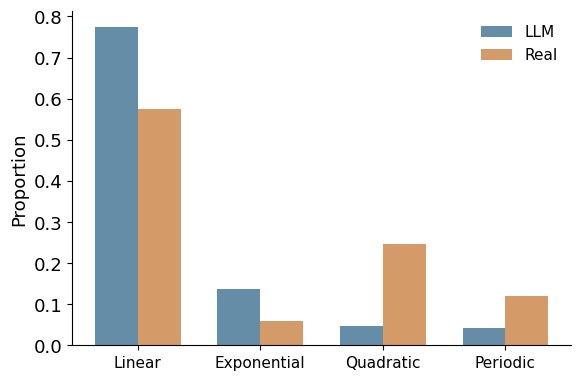

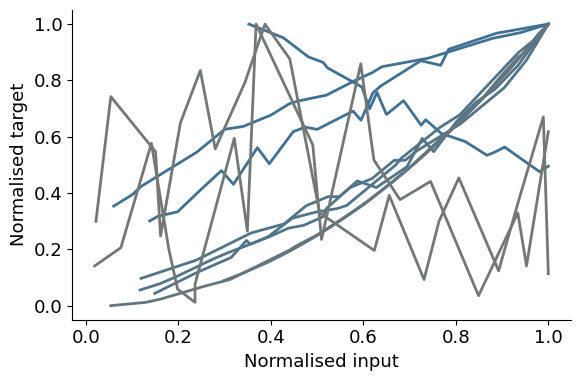

[0.021509223003113503, 0.01579531155327587]
[0.3034197824499079, 0.3011539673703673]


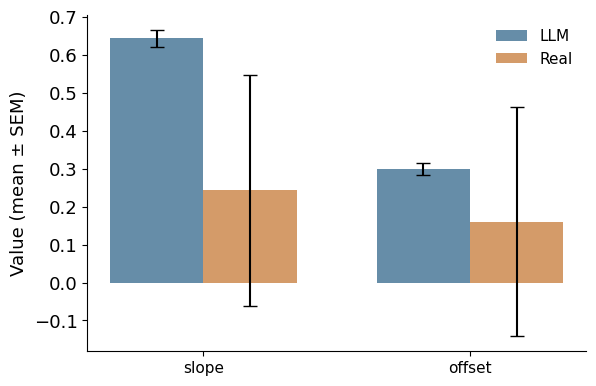

In [46]:
proportion_function_types_two_modes([0, 2])

In [2]:
def model_extrapolation_delosh1997(model='ermi', FIGSIZE=(6, 4), offset=False, FONTSIZE=13):
    # load model
    if offset:
        results_ermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/env=claude_dim1_maxsteps25_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_kwantes2006.npz')
        results_mi = np.load(f'{PARADIGM_PATH}/data/model_simulation/env=synthetic_dim1_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.01_shuffleTrue_run=0_synthetic_kwantes2006.npz')
    else:
        results_ermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/env=claude_dim1_maxsteps25_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_delosh1997.npz')
        # env=claude_dim1_maxsteps65_model=transformer_num_episodes250000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_ess0.0_run=0_regall_essinit0.0_annealed_schedulefree_dynamic_scaling_delosh1997.npz')
        results_mi = np.load(f'{PARADIGM_PATH}/data/model_simulation/env=synthetic_dim1_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.01_shuffleTrue_run=0_synthetic_delosh1997.npz')
        # env=synthetic_dim1_maxsteps65_dim1_model=transformer_num_episodes250000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.01_shuffleTrue_ess0.0_run=0_synthetic_regall_essinit0.0_annealed_schedulefree_dynamic_scaling_delosh1997.npz')

    # Extract unique functions and calculate MSE for results_ermi
    functions = ['linear_offset'] if offset else ['linear']#, 'exponential', 'quadratic']
    function_names = {'linear': 'Linear', 'exponential': 'Exponential', 'quadratic': 'Quadratic', 'linear_offset': 'Linear with Offset'}
    error_dict_ermi = {'Function': [], 'MSE': [], 'Dataset': [], 'Input': [], 'Target': [], 'Extrapolation_Input': [], 'Extrapolation_Target': [], 'Per_trial_MSE': []}
    error_dict_mi = {'Function': [], 'MSE': [], 'Dataset': [], 'Input': [], 'Target': [], 'Extrapolation_Input': [], 'Extrapolation_Target': [], 'Per_trial_MSE': []}
    for function in functions:
        mse = results_ermi['model_errors'].squeeze()[(results_ermi['ground_truth_functions'] == function)].mean()
        input_data = results_ermi['human_preds'].squeeze()[(results_ermi['ground_truth_functions'] == function)][:, :-1]
        target_data = results_ermi['targets'].squeeze()[(results_ermi['ground_truth_functions'] == function)][:, :-1]
        extrapolation_input = results_ermi['human_preds'].squeeze()[(results_ermi['ground_truth_functions'] == function)][:, -1]
        extrapolation_target = results_ermi['model_preds'].squeeze()[(results_ermi['ground_truth_functions'] == function)][:, -1]
        num_trials = results_ermi['per_trial_model_errors'].shape[-1]
        ground_truth_functions_repeated = np.repeat(results_ermi['ground_truth_functions'][:, :, np.newaxis], num_trials, axis=2).reshape(-1, num_trials)
        per_trial_mse = results_ermi['per_trial_model_errors'].reshape(-1, num_trials)[(ground_truth_functions_repeated == function)].reshape(-1, num_trials)
        error_dict_ermi['Function'].append(function_names[function])
        error_dict_ermi['MSE'].append(mse)
        error_dict_ermi['Dataset'].append('ERMI')
        error_dict_ermi['Input'].append(input_data)
        error_dict_ermi['Target'].append(target_data)
        error_dict_ermi['Extrapolation_Input'].append(extrapolation_input)
        error_dict_ermi['Extrapolation_Target'].append(extrapolation_target)
        error_dict_ermi['Per_trial_MSE'].append(per_trial_mse)
        
        mse = results_mi['model_errors'].squeeze()[(results_mi['ground_truth_functions'] == function)].mean()
        input_data = results_mi['human_preds'].squeeze()[(results_mi['ground_truth_functions'] == function)][:, :-1]
        target_data = results_mi['targets'].squeeze()[(results_mi['ground_truth_functions'] == function)][:, :-1]
        extrapolation_input = results_mi['human_preds'].squeeze()[(results_mi['ground_truth_functions'] == function)][:, -1]
        extrapolation_target = results_mi['model_preds'].squeeze()[(results_mi['ground_truth_functions'] == function)][:, -1]
        per_trial_mse = results_mi['per_trial_model_errors'].reshape(-1, num_trials)[(ground_truth_functions_repeated == function)].reshape(-1, num_trials)
        error_dict_mi['Function'].append(function_names[function])
        error_dict_mi['MSE'].append(mse)
        error_dict_mi['Dataset'].append('RMF')
        error_dict_mi['Input'].append(input_data)
        error_dict_mi['Target'].append(target_data)
        error_dict_mi['Extrapolation_Input'].append(extrapolation_input)
        error_dict_mi['Extrapolation_Target'].append(extrapolation_target)
        error_dict_mi['Per_trial_MSE'].append(per_trial_mse)

    # Combine the data into a single DataFrame
    df_ermi = pd.DataFrame(error_dict_ermi)
    df_mi = pd.DataFrame(error_dict_mi)
    if model == 'ermi':
        df_combined = pd.concat([df_ermi])
    elif model == 'mi':
        df_combined = pd.concat([df_mi])
    else:
        df_combined = pd.concat([df_ermi, df_mi])

    # scatter plot of Input vs Target and Extrapolation Input vs Extrapolation Target for each function
    def linear(x):
        return 2.2 * x + 30
    
    x = np.linspace(1., 101., 100)
    y = linear(x)
    human_data = pd.read_csv(f'{PARADIGM_PATH}/data/human/kwantes2006extrapolation.csv')

    # y = y/250 - 0.5
    # x = x/100 - 0.5
    # sns.set(style="whitegrid")
    if model == 'both':
        fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    for dataset in df_combined['Dataset'].unique():
        extra_inputs = []
        extra_targets = []
        for function in df_combined['Function'].unique():
            subset = df_combined[(df_combined['Function'] == function) & (df_combined['Dataset'] == dataset)]
            if model!='both':
                fig, axs = plt.subplots(1, 1, figsize=(6, 4))
            for i, row in subset.iterrows():
                # axs.scatter((row['Extrapolation_Input']+0.5)*100, (row['Extrapolation_Target']+0.5)*250, label=dataset, alpha=1.0, color='#5975a4ff' if dataset == "ERMI" else '#cc8963ff')
                extra_inputs.append((row['Extrapolation_Input']+0.5)*100)
                extra_targets.append((row['Extrapolation_Target']+0.5)*250)
            # import ipdb; ipdb.set_trace()
            extra_inputs, extra_targets = zip(*sorted(zip(extra_inputs[0], extra_targets[0])))
            axs.plot(extra_inputs,extra_targets, label=dataset, alpha=1.0, color='#5975a4ff' if dataset == "ERMI" else '#cc8963ff')
            axs.set_xlabel('Input', fontsize=FONTSIZE)
            axs.set_ylabel('Target', fontsize=FONTSIZE)
            axs.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
            axs.legend(frameon=False, fontsize=FONTSIZE-2)
            # add vertical dotted line as a separator at x = -0.5 and x = 0.5
            # axs.axvline(x=-0.25, color='black', linestyle='--', alpha=0.5)
            # axs.axvline(x=0.25, color='black', linestyle='--', alpha=0.5)
            plt.grid(visible=False)
            plt.ylim(-2, 300)
            sns.despine()
            if model!='both':
                axs.plot(x, y, label='Correct', color='black', linestyle='-')
                plt.savefig(f'{SYS_PATH}/figures/functionlearning_extrapolation_function={function}_model={dataset}_offset={str(offset)}.png', bbox_inches='tight')
            # plt.show()
    
    if model == 'both':
        axs.scatter(human_data['x'], human_data['y'], label='Human', color='green', alpha=0.5, lw=0.1)
        axs.plot(x, y, label='Correct', color='black', linestyle='--')
        axs.legend(frameon=False, fontsize=FONTSIZE-2)
        plt.savefig(f'{SYS_PATH}/figures/functionlearning_extrapolation_function={function}_model={dataset}_offset={str(offset)}.png', bbox_inches='tight')


In [ ]:
def interpolation_and_extrapolation_little2024(FIGSIZE=(6,4), experiment_ids=[1,3], bermi=False, FONTSIZE=13):
    results = {}
    fig, ax = plt.subplots(figsize=FIGSIZE)
    bar_width = 0.35
    x = np.arange(len(experiment_ids))  # the label locations

    for i, experiment_id in enumerate(experiment_ids):
        rmf = np.load(f'{PARADIGM_PATH}/data/model_simulation/task=little2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
        ermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/task=little2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
        df = pd.DataFrame.from_dict({
                                    'ERMI':ermi['model_errors'].mean(1).squeeze(), 
                                    'RMF':rmf['model_errors'].mean(1).squeeze(), 
                                    })

        ax.bar(x[i] - bar_width/2, df['ERMI'].mean(), bar_width, label=f'ERMI', color='#5975a4ff')
        ax.bar(x[i] + bar_width/2, df['RMF'].mean(), bar_width, label=f'RMF', color='#cc8963ff')
        ax.errorbar(x[i] - bar_width/2, df['ERMI'].mean(), yerr=df['ERMI'].std()/np.sqrt(len(df['ERMI'])), fmt='o', color='black', capsize=5)
        ax.errorbar(x[i] + bar_width/2, df['RMF'].mean(), yerr=df['RMF'].std()/np.sqrt(len(df['RMF'])), fmt='o', color='black', capsize=5)

    ax.set_xticks(x)
    ax.set_xticklabels(['Interpolation' if experiment_id==1 else 'Extraplation' for experiment_id in experiment_ids])
    sns.despine()
    ax.set_ylabel('Mean-squared Error', fontsize=FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
    # ax.legend(frameon=False, fontsize=FONTSIZE-2)
    plt.grid(visible=False)
    plt.savefig(f'{SYS_PATH}/figures/functionlearning_model_comparison_little2024_combined.png', bbox_inches='tight')
    plt.show()

In [ ]:
SYS_PATH = '/u/ajagadish/ermi'
PARADIGM_PATH = f"{SYS_PATH}/functionlearning"
mode=0      
def test(plot_model='together', FIGSIZE=(6,4), experiment_id=1, bermi=False, FONTSIZE=13):
    task_name = 'little2022'
    if bermi:
        rmf = np.load(f'{PARADIGM_PATH}/data/model_simulation/task=little2022_experiment=1_source=synthetic_condition=unknown_loss=nll_paired=False_method=unbounded.npz')
        ermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/task=little2022_experiment=1_source=claude_condition=unknown_loss=nll_paired=False_method=unbounded.npz')
        bermi = np.load(f'{PARADIGM_PATH}/data/model_comparison/task=little2022_experiment=1_source=claude_condition=unknown_loss=nll_paired=False_method=bounded.npz')
        bmi = np.load(f'{PARADIGM_PATH}/data/model_comparison/task=little2022_experiment=1_source=synthetic_condition=unknown_loss=nll_paired=False_method=bounded.npz')
        # ref = np.load(f'{PARADIGM_PATH}/data/model_simulation/env=synthetic_dim1_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.01_shuffleTrue_run=0_synthetic.npz')
        df = pd.DataFrame.from_dict({
                                    'BERMI':bermi['nlls'],
                                    'BMI':bmi['nlls'],
                                    'ERMI':ermi['nlls'],
                                    'RMF':rmf['nlls'],
                                    })
    else:
        rmf = np.load(f'{PARADIGM_PATH}/data/model_simulation/task=little2022_experiment={experiment_id}_source=synthetic_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
        ermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/task=little2022_experiment={experiment_id}_source=claude_condition=unknown_loss=nll_paired=False_policy=greedy.npz')
        df = pd.DataFrame.from_dict({
                                    'ERMI':ermi['model_errors'].mean(1).squeeze(), 
                                    'RMF':rmf['model_errors'].mean(1).squeeze(), 
                                    })

    fig, ax = plt.subplots(figsize=FIGSIZE)
    # sns.barplot(data=df, capsize=.1, errorbar="se", ax=ax)
    ax.bar(['ERMI', 'RMF'], [df['ERMI'].mean(), df['RMF'].mean()], color=['#5975a4ff', '#cc8963ff'])
    ax.errorbar(['ERMI', 'RMF'], [df['ERMI'].mean(), df['RMF'].mean()], yerr=[df['ERMI'].std()/np.sqrt(len(df['ERMI'])), df['RMF'].std()/np.sqrt(len(df['RMF']))], fmt='o', color='black', capsize=5)
    # sns.swarmplot(data=df, color="0", alpha=.35, ax=ax)
    sns.despine()
    ax.set_ylabel('Mean-squared Error', fontsize=FONTSIZE)
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
    plt.grid(visible=False)
    plt.savefig(f'{SYS_PATH}/figures/functionlearning_model_comparison_little2024_expid{experiment_id}.png', bbox_inches='tight')
    plt.show()
    
    if bermi:
        bermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/task={task_name}_experiment=1_source=claude_condition=unknown_loss=nll_paired=False_policy=greedy_ess={str(bermi["ess"][np.argmin(bermi["nlls"])])}.npz')
        bmi = np.load(f'{PARADIGM_PATH}/data/model_simulation/task={task_name}_experiment=1_source=synthetic_condition=unknown_loss=nll_paired=False_policy=greedy_ess={str(bmi["ess"][np.argmin(bmi["nlls"])])}.npz')
        ermi = np.load(f'{PARADIGM_PATH}/data/model_simulation/task={task_name}_experiment=1_source=claude_condition=unknown_loss=nll_paired=False_policy=greedy_ess=0.0.npz')
        rmf = np.load(f'{PARADIGM_PATH}/data/model_simulation/task={task_name}_experiment=1_source=synthetic_condition=unknown_loss=nll_paired=False_policy=greedy_ess=0.0.npz')   
        models = [bermi, bmi, ermi, rmf]
        subjects = [np.argmin(bermi['nlls']), np.argmin(bmi['nlls']), np.argmin(ermi['model_errors'].mean(1).squeeze()), np.argmin(rmf['model_errors'].mean(1).squeeze())] # best parrticipant for each model
        model_names =  ['BERMI', 'BMI', 'ERMI', 'RMF']
    else:
        models = [ermi, rmf] 
        subjects =  [np.argmin(ermi['model_errors'].mean(1).squeeze()), np.argmin(ermi['model_errors'].mean(1).squeeze())]# np.argmin(rmf['model_errors'].mean(1).squeeze())]
        model_names =  ['ERMI', 'RMF']

    num_functions =  models[0]['human_preds'].shape[1]
    num_participants =  models[0]['model_preds'].shape[0]
    num_data = 20 if experiment_id == 1 or experiment_id == 3 else 5
    
    if plot_model=='together':
        _, axs = plt.subplots(1, num_functions, figsize=(6*num_functions, 4))
    for first, (subject, model, model_name) in enumerate(zip(subjects, models, model_names)):
        ref = rmf if model_name == 'RMF' else ermi if model_name == 'ERMI' else bmi if model_name == 'BMI' else bermi
        if plot_model == 'separate':
            _, axs = plt.subplots(1, num_functions, figsize=(6*num_functions, 4))
        for function in range(num_functions):
            axs[function].plot(model['human_preds'][subject, function, :, 0], model['model_preds'].reshape(num_participants, num_functions, num_data)[subject, function], lw=2, label=model_name)
            if first ==0 and plot_model == 'together':
                axs[function].scatter(ref['ground_truth_functions'][subject, function, :, 0], ref['ground_truth_functions'][subject, function, :, 1], c='black')#, label="Ground Truth")
                axs[function].plot(ref['human_preds'][subject, function, :, 0], ref['human_preds'][subject, function, :, 1], c='green', lw=2, label='Human')
            elif plot_model == 'separate':
                axs[function].scatter(ref['ground_truth_functions'][subject, function, :, 0], ref['ground_truth_functions'][subject, function, :, 1], c='black')#, label="Ground Truth")
                axs[function].plot(ref['human_preds'][subject, function, :, 0], ref['human_preds'][subject, function, :, 1], c='green', lw=2, label='Human')
                
            axs[function].grid(visible=False)
            # if function == 0:
            axs[function].set_xlabel('Input', fontsize=FONTSIZE)
            axs[function].set_ylabel('Target', fontsize=FONTSIZE)
            axs[function].legend(frameon=False, fontsize=FONTSIZE-4)
        if plot_model == 'separate':
            axs[function].tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
            sns.despine()
            plt.tight_layout()
            plt.savefig(f'{SYS_PATH}/figures/functionlearning_model_comparison_little2024_functions_subject{subject}_model{model_name}_expid{experiment_id}.png', bbox_inches='tight')
            plt.show()
    if plot_model == 'together':
        axs[function].tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
        sns.despine()
        plt.tight_layout()
        plt.savefig(f'{SYS_PATH}/figures/functionlearning_model_comparison_little2024_functions_subject{subject}_model{model_name}_expid{experiment_id}.png', bbox_inches='tight')
        plt.show()
        
#     for subject in subjects:
#         for function in range(num_functions):
#             _, axs = plt.subplots(1, 1, figsize=(6, 4))
#             for (model, model_name) in zip(models, model_names):
#                 ref = rmf if model_name == 'RMF' else ermi if model_name == 'ERMI' else bmi if model_name == 'BMI' else bermi
#                 # sns.set(style="whitegrid")   
#                 axs.scatter(ref['ground_truth_functions'][subject, function, :, 0], ref['ground_truth_functions'][subject, function, :, 1], c='black', label="Ground Truth")
                
#                 if function == 0:
#                     axs.set_xlabel('Input', fontsize=FONTSIZE)
#                     axs.set_ylabel('Target', fontsize=FONTSIZE)
#                     axs.legend(frameon=False, fontsize=FONTSIZE-4)

#                 axs.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
#                 axs.grid(visible=False)
#                 sns.despine()
#                 plt.tight_layout()
#                 plt.savefig(f'{SYS_PATH}/figures/functionlearning_model_comparison_little2024_functions_subject{subject}_model{model_name}_expid{experiment_id}_{function}_gt.png', bbox_inches='tight')
#                 if function == 0:
#                     axs.legend(frameon=False, fontsize=FONTSIZE-4)

#                 axs.plot(ref['human_preds'][subject, function, :, 0], ref['human_preds'][subject, function, :, 1], c='green', lw=2, label='Human')
#                 plt.savefig(f'{SYS_PATH}/figures/functionlearning_model_comparison_little2024_functions_subject{subject}_model{model_name}_expid{experiment_id}_{function}_gthuman.png', bbox_inches='tight')

#                 if function == 0:
#                     axs.legend(frameon=False, fontsize=FONTSIZE-4)
                
#                 axs.plot(model['human_preds'][subject, function, :, 0], model['model_preds'].reshape(num_participants, num_functions, num_data)[subject, function], lw=2, label=model_name)
#                 plt.savefig(f'{SYS_PATH}/figures/functionlearning_model_comparison_little2024_functions_subject{subject}_model{model_name}_expid{experiment_id}_{function}.png', bbox_inches='tight')

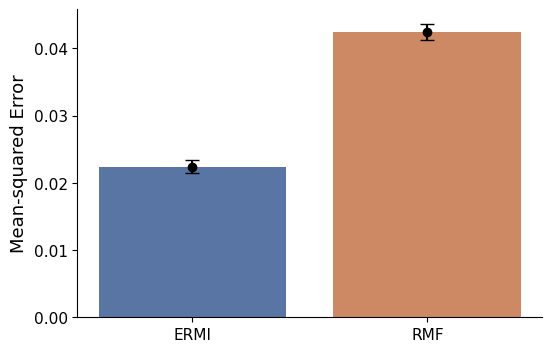

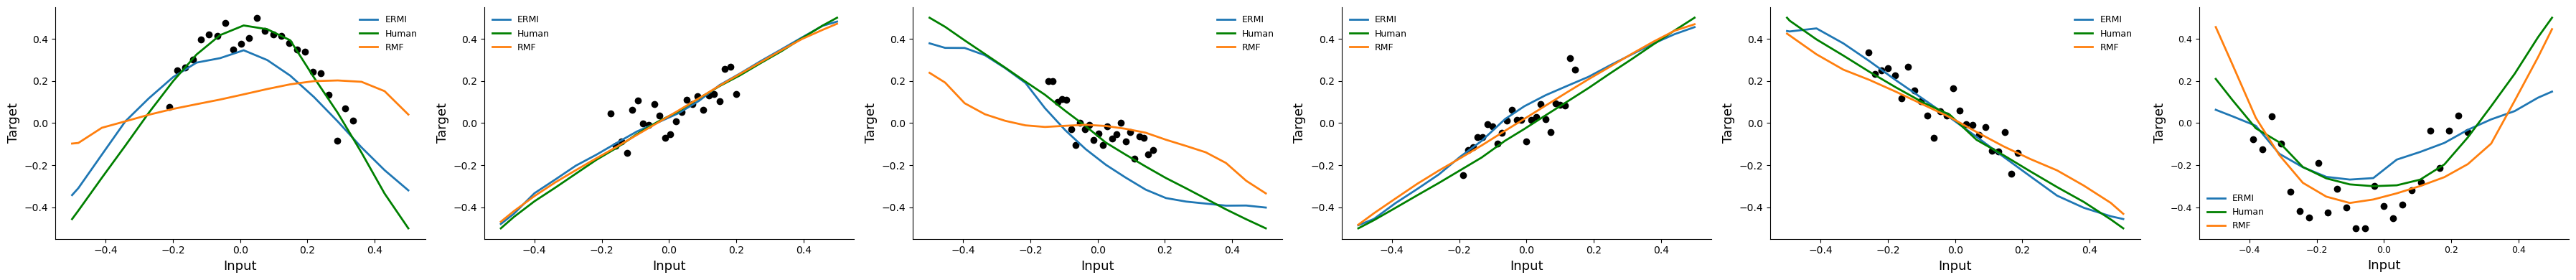

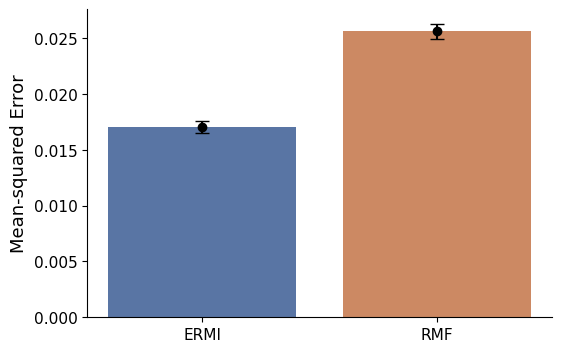

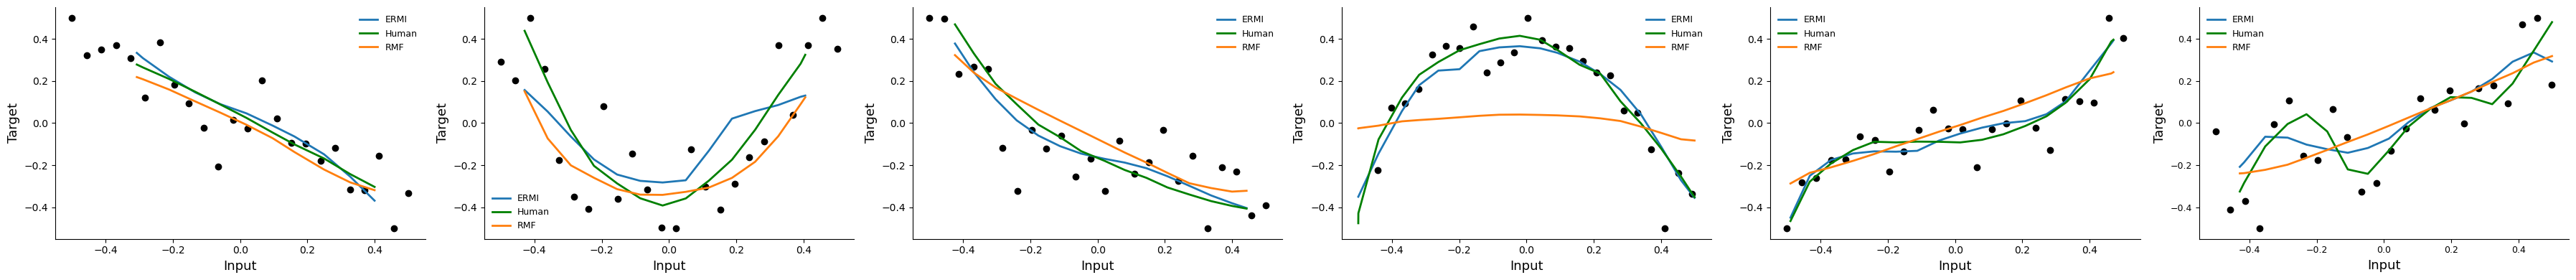

In [15]:
test(plot_model='together', experiment_id=3)
test(plot_model='together', experiment_id=1)

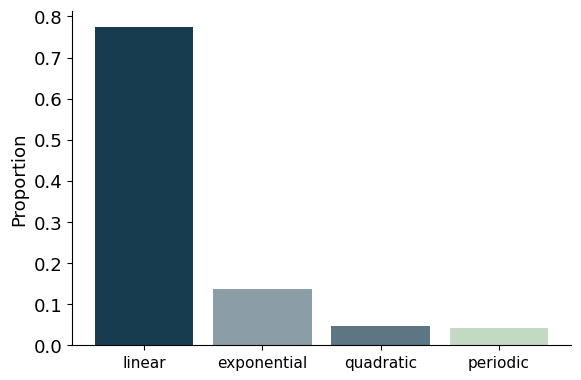

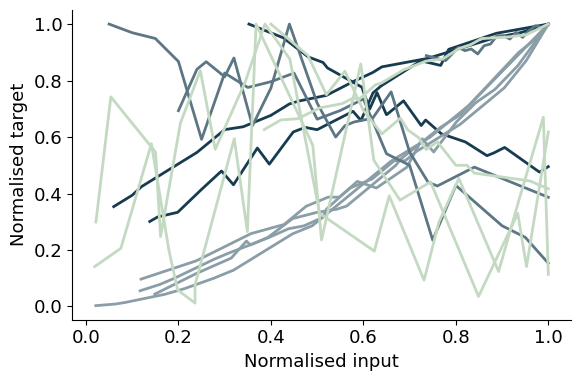

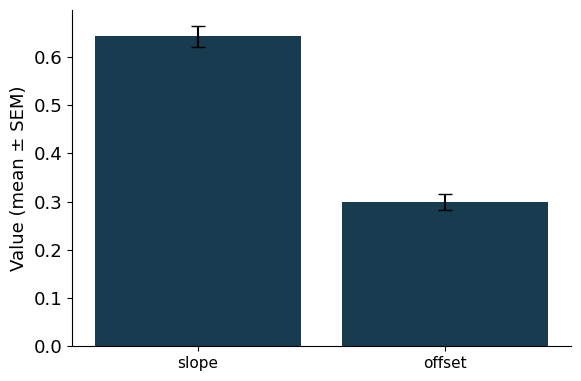

In [10]:
SYS_PATH = '/u/ajagadish/ermi'
PARADIGM_PATH = f"{SYS_PATH}/functionlearning"
mode=0

# set env_name and color_stats based on mode
if mode == 0:
    env_name = f'{PARADIGM_PATH}/data/generated_tasks/claude_generated_functionlearningtasks_paramsNA_dim1_data20_tasks9991_run0_procid0_pversion2.csv'
    color_stats = '#405A63'  # '#2F4A5A'# '#173b4f'
elif mode == 1:  
    env_name = f'{PARADIGM_PATH}/data/generated_tasks/synthetic_functionlearning_tasks_dim1_data25_tasks10000.csv'
    color_stats = '#66828F'  # 5d7684'# '#5d7684'
elif mode == 2: 
    env_name = f'{PARADIGM_PATH}/data/generated_tasks/real_data_dim1_methodbest_lichtenberg2017.csv'
    color_stats = '#173b4f'  # '#0D2C3D' #'#8b9da7'

df = pd.read_csv(env_name)
first=True
max_tasks = 1000
tasks = range(0, max_tasks) if first else np.random.choice(df.task_id.unique(), max_tasks, replace=False)
df = df[df['task_id'].isin(tasks)]

# parse single-element list strings
def parse_val(v):
    try:
        
        
        return eval(str(v))[0]
    except:
        return float(str(v).strip("[]"))

df["input"] = df["input"].apply(parse_val)
df["target"] = df["target"].apply(parse_val)

# per-task max-abs normalization
df["input"] = df.groupby("task_id")["input"].transform(lambda x: x / np.abs(x).max() if x.max()!=0 else x)
df["target"] = df.groupby("task_id")["target"].transform(lambda x: x / np.abs(x).max() if x.max()!=0 else x)
    
model_df = pd.read_csv(f"{PARADIGM_PATH}/data/stats/fitted_model_params_function_types_{str(mode)}.csv")
linear_params = pd.read_csv(f"{PARADIGM_PATH}/data/stats/fitted_linear_model_params_function_types_{str(mode)}.csv")
# Settings
FONTSIZE=13
plt.rcParams.update({"font.size": FONTSIZE})
functions=["linear", "exponential", "quadratic", "periodic"]
colors=["#173b4f","#8b9da7",'#5d7684', '#c4d9c2'][:len(functions)]
props=model_df["model"].value_counts(normalize=True).reindex(functions,fill_value=0)
plt.figure(figsize=(6,4))
pos=np.arange(len(functions))*0.6
plt.bar(pos,props.values,color=colors,width=0.5)
plt.xticks(pos,functions,fontsize=FONTSIZE-2); plt.ylabel("Proportion"); 
# plt.title("Proportion of best models"); 
sns.despine(); plt.grid(False); plt.tight_layout(); plt.show()

# overlay plot
plt.figure(figsize=(6,4))
n_best=3
# test=["periodic"]
for idx, model in enumerate(functions):
    top=model_df[model_df["model"]==model][44:47]#[47:53]
    if mode == 0:
        if model=='periodic':
            top = model_df[model_df["model"]==model][6:10]
        elif model == 'exponential':
            top = model_df[model_df["model"]==model].loc[model_df[model_df["model"]==model]['p2'].sort_values()[-14:-10].index.values]

    for tid in top["task_id"]:
        g=df[df["task_id"]==tid]
        xs=g["input"].values.astype(float); ys=g["target"].values.astype(float)
        ord=np.argsort(xs); plt.plot(xs[ord],ys[ord],color=colors[idx],lw=2)
        plt.xlabel("Normalised input"); plt.ylabel("Normalised target"); 

# plt.title(f"Top‑{n_best} functions per model"); 
plt.grid(False);  sns.despine(); plt.tight_layout(); plt.show()
# linear coeffs plot
slopes = linear_params["slope"].values
offs = linear_params["offset"].values
means=[slopes.mean(),offs.mean()]; stds=[slopes.std(ddof=1)/np.sqrt(len(slopes)),offs.std(ddof=1)/np.sqrt(len(slopes))]
plt.figure(figsize=(6,4))
xp=np.arange(2)*0.6; plt.bar(xp,means,yerr=stds,width=0.5,color=colors[0],capsize=5)
plt.xticks(xp,["slope","offset"],fontsize=FONTSIZE-2)
plt.ylabel("Value (mean ± SEM)"); 
# plt.title("Linear coefficients"); 
plt.grid(False); sns.despine(); plt.tight_layout(); plt.show()

In [52]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, math, warnings, time
from scipy.optimize import minimize_scalar
FONTSIZE=13
plt.rcParams.update({"font.size":FONTSIZE})
mode = 0
# set env_name and color_stats based on mode
if mode == 0:
    env_name = f'{SYS_PATH}/functionlearning/data/generated_tasks/claude_generated_functionlearningtasks_paramsNA_dim1_data20_tasks9991_run0_procid0_pversion2.csv'
    color_stats = '#405A63'  # '#2F4A5A'# '#173b4f'
elif mode == 1:  
    env_name = f'{SYS_PATH}/functionlearning/data/generated_tasks/synthetic_functionlearning_tasks_dim1_data25_tasks10000.csv'
    color_stats = '#66828F'  # 5d7684'# '#5d7684'
elif mode == 2: 
    env_name = f'{SYS_PATH}/functionlearning/data/generated_tasks/real_data_dim1_methodrandom_lichtenberg2017.csv'
    color_stats = '#173b4f'  # '#0D2C3D' #'#8b9da7'

first=True
plot_df=pd.read_csv(env_name)
max_tasks = 1000
tasks = range(0, max_tasks) if first else np.random.choice(plot_df.task_id.unique(), max_tasks, replace=False)
plot_df = plot_df[plot_df['task_id'].isin(tasks)]
plot_df["input"]=plot_df["input"].apply(lambda v: eval(str(v))[0] if isinstance(v,str) else v)
plot_df["target"]=plot_df["target"].apply(lambda v: eval(str(v))[0] if isinstance(v,str) else v)
plot_df["input"]=plot_df.groupby("task_id")["input"].transform(lambda x:x/np.abs(x).max() if x.max()!=0 else x)
plot_df["target"]=plot_df.groupby("task_id")["target"].transform(lambda x:x/np.abs(x).max() if x.max()!=0 else x)


def bic(sse,n,k):
    if sse<=0 or n<=k: return np.inf
    return k*math.log(n)+n*math.log(sse/n)

def safe_polyfit(x,y,deg):
    try:
        return np.polyfit(x,y,deg)
    except Exception:
        raise
        
def bic_linear(x,y):
    try:
        a,b=safe_polyfit(x,y,1)
        sse=np.sum((y-(a*x+b))**2)
        return bic(sse,len(x),2),(a,b)
    except Exception:
        return np.inf,(np.nan,np.nan)
    
def bic_quad(x,y):
    if len(np.unique(x))<2: return np.inf,(np.nan,np.nan)
    try:
        X=np.vstack([x**2,np.ones_like(x)]).T
        a,c=np.linalg.lstsq(X,y,rcond=None)[0]
        sse=np.sum((y-(a*x**2+c))**2)
        return bic(sse,len(x),2),(a,c)
    except Exception:
        return np.inf,(np.nan,np.nan)
    
def bic_exp(x,y):
    d0=y.min()*0.95
    ys=y-d0
    if np.any(ys<=0): return np.inf,(np.nan,np.nan,np.nan)
    try:
        b,lnA=safe_polyfit(x,np.log(ys),1)
        a=np.exp(lnA); sse=np.sum((y-(a*np.exp(b*x)+d0))**2)
        return bic(sse,len(x),3),(a,b,d0)
    except Exception:
        return np.inf,(np.nan,np.nan,np.nan)
    
# freqs=[2*np.pi*k for k in range(1,5)]
# def bic_per(x,y):
#     best=np.inf; params=(np.nan,np.nan,np.nan)
#     for w in freqs:
#         try:
#             sin=np.sin(w*x); X=np.vstack([sin,np.ones_like(x)]).T
#             a,d=np.linalg.lstsq(X,y,rcond=None)[0]
#             sse=np.sum((y-(a*sin+d))**2)
#             val=bic(sse,len(x),3)
#             if val<best: best,params=val,(a,w,d)
#         except Exception:
#             continue
#     return best,params

def sine_sse(x,y,b):
    s=np.sin(b*x)
    ss=np.dot(s,s); sum_s=s.sum(); sy=np.dot(s,y); n=len(x)
    det=ss*n - sum_s**2
    if det==0: return np.inf,(0,0)
    a=(n*sy - sum_s*y.sum())/det
    d=(ss*y.sum() - sum_s*sy)/det
    resid=y-(a*s+d)
    return np.dot(resid,resid),(a,d)

def bic_per(x,y):
    try:
        res=minimize_scalar(lambda b: sine_sse(x,y,b)[0],
                            bounds=(0.5*np.pi,12*np.pi),
                            method='bounded',
                            options={'xatol':1e-2})
        if not res.success: return np.inf,(np.nan,np.nan,np.nan)
        sse,(a,d)=sine_sse(x,y,res.x)
        return bic(sse,len(x),3),(a,res.x,d)
    except: return np.inf,(np.nan,np.nan,np.nan)

bic_map={"linear":bic_linear,"quadratic":bic_quad,"exponential":bic_exp,"periodic":bic_per}
records=[]; linear_coeffs=[]
warnings.filterwarnings("ignore")
for tid,g in plot_df.groupby("task_id"):
    x=g["input"].values.astype(float); y=g["target"].values.astype(float)
    if len(x)<2: continue
    best=np.inf; m=None; prm=(np.nan,np.nan,np.nan)
    for name,fn in bic_map.items():
        val,pars=fn(x,y)
        if val<best:
            best=val; m=name; prm=pars
    records.append((tid,m,best)+prm)
    if m=="linear": linear_coeffs.append(prm)

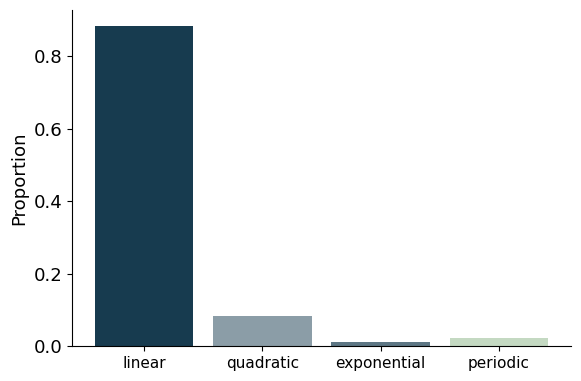

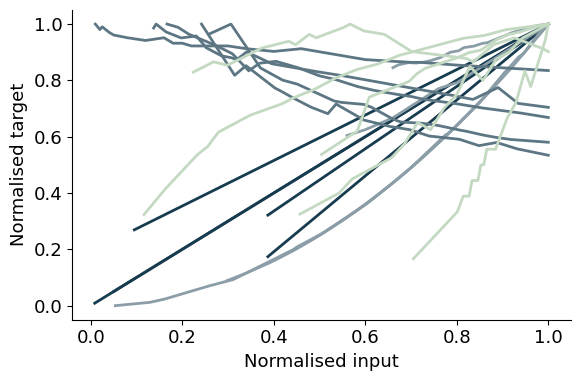

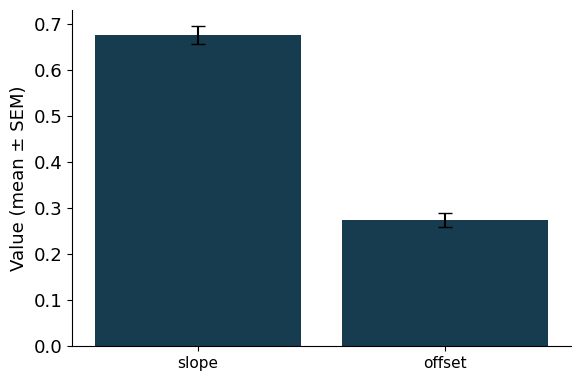

In [54]:
functions=["linear","quadratic", "exponential", "periodic"]
colors=["#173b4f","#8b9da7",'#5d7684', '#c4d9c2'][:len(functions)]
model_df=pd.DataFrame(records,columns=["task_id","model","bic","p1","p2","p3"])
props=model_df["model"].value_counts(normalize=True).reindex(functions,fill_value=0)
plt.figure(figsize=(6,4))
pos=np.arange(len(functions))*0.6
plt.bar(pos,props.values,color=colors,width=0.5)
plt.xticks(pos,functions,fontsize=FONTSIZE-2); plt.ylabel("Proportion"); 
# plt.title("Proportion of best models"); 
sns.despine(); plt.grid(False); plt.tight_layout(); plt.show()

# overlay plot
plt.figure(figsize=(6,4))
n_best=5
for idx,model in enumerate(functions):
    top=model_df[model_df["model"]==model].nsmallest(n_best, "bic")
    for tid in top["task_id"]:
        g=plot_df[plot_df["task_id"]==tid]
        xs=g["input"].values.astype(float); ys=g["target"].values.astype(float)
        ord=np.argsort(xs); plt.plot(xs[ord],ys[ord],color=colors[idx],lw=2)
plt.xlabel("Normalised input"); plt.ylabel("Normalised target"); 
# plt.title(f"Top‑{n_best} functions per model"); 
plt.grid(False);  sns.despine(); plt.tight_layout(); plt.show()
# linear coeffs plot
if linear_coeffs:
    slopes=np.array([t[0] for t in linear_coeffs if not np.isnan(t[0])])
    offs=np.array([t[1] for t in linear_coeffs if not np.isnan(t[1])])
    means=[slopes.mean(),offs.mean()]; stds=[slopes.std(ddof=1)/np.sqrt(len(slopes)),offs.std(ddof=1)/np.sqrt(len(slopes))]
    plt.figure(figsize=(6,4))
    xp=np.arange(2)*0.6; plt.bar(xp,means,yerr=stds,width=0.5,color=colors[0],capsize=5)
    plt.xticks(xp,["slope","offset"],fontsize=FONTSIZE-2)
    plt.ylabel("Value (mean ± SEM)"); 
    # plt.title("Linear coefficients"); 
    plt.grid(False); sns.despine(); plt.tight_layout(); plt.show()

In [12]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, math, warnings, time
from scipy.optimize import curve_fit

# Settings
SYS_PATH = '/u/ajagadish/ermi' #'/raven/u/ajagadish/vanilla-llama/'

# 1. Load and preprocess
mode = 2
# set env_name and color_stats based on mode
if mode == 0:
    env_name = f'{SYS_PATH}/functionlearning/data/generated_tasks/claude_generated_functionlearningtasks_paramsNA_dim1_data20_tasks9991_run0_procid0_pversion2.csv'
    color_stats = '#405A63'  # '#2F4A5A'# '#173b4f'
elif mode == 1:  
    env_name = f'{SYS_PATH}/functionlearning/data/generated_tasks/synthetic_functionlearning_tasks_dim1_data25_tasks10000.csv'
    color_stats = '#66828F'  # 5d7684'# '#5d7684'
elif mode == 2: 
    env_name = f'{SYS_PATH}/functionlearning/data/generated_tasks/real_data_dim1_methodbest_lichtenberg2017.csv'
    color_stats = '#173b4f'  # '#0D2C3D' #'#8b9da7'
    
df = pd.read_csv(env_name)
first=True
max_tasks = 1000
tasks = range(0, max_tasks) if first else np.random.choice(df.task_id.unique(), max_tasks, replace=False)
df = df[df['task_id'].isin(tasks)]

# parse single-element list strings
def parse_val(v):
    try:
        return eval(str(v))[0]
    except:
        return float(str(v).strip("[]"))

df["input"] = df["input"].apply(parse_val)
df["target"] = df["target"].apply(parse_val)

# per-task max-abs normalization
df["input"] = df.groupby("task_id")["input"].transform(lambda x: x / np.abs(x).max() if x.max()!=0 else x)
df["target"] = df.groupby("task_id")["target"].transform(lambda x: x / np.abs(x).max() if x.max()!=0 else x)

# 2. BIC helper
def bic(sse, n, k):
    if sse <= 0 or n <= k:
        return np.inf
    return k*math.log(n) + n*math.log(sse/n)

# 3. Model definitions
def linear_model(x, a, b):
    return a*x + b

def quadratic_model(x, a, c):
    return a*x**2 + c

def exponential_model(x, a, b, d):
    return a * np.exp(b*x) + d

def sine_model(x, a, b, d):
    return a * np.sin(b*x) + d

# 4. BIC calculators
def bic_linear(x, y):
    try:
        popt, _ = curve_fit(linear_model, x, y, p0=[1, 0], maxfev=2000)
        sse = ((y - linear_model(x, *popt))**2).sum()
        return bic(sse, len(x), 2), popt
    except:
        return np.inf, (np.nan, np.nan)

def bic_quadratic(x, y):
    try:
        popt, _ = curve_fit(quadratic_model, x, y, p0=[1, 0], maxfev=2000)
        sse = ((y - quadratic_model(x, *popt))**2).sum()
        return bic(sse, len(x), 2), popt
    except:
        return np.inf, (np.nan, np.nan)

def bic_exponential(x, y):
    try:
        p0 = [(y.max()-y.min())/2, 1.0, y.min()]
        bounds = ([-np.inf, 0, -np.inf], np.inf)
        popt, _ = curve_fit(exponential_model, x, y, p0=p0, bounds=bounds, maxfev=5000)
        sse = ((y - exponential_model(x, *popt))**2).sum()
        return bic(sse, len(x), 3), popt
    except:
        return np.inf, (np.nan, np.nan, np.nan)

def bic_periodic(x, y):
    try:
        p0 = [(y.max()-y.min())/2, 2*np.pi, y.mean()]
        bounds = ([-np.inf, 0, -np.inf], np.inf)
        popt, _ = curve_fit(sine_model, x, y, p0=p0, bounds=bounds, maxfev=5000)
        sse = ((y - sine_model(x, *popt))**2).sum()
        return bic(sse, len(x), 3), popt
    except:
        return np.inf, (np.nan, np.nan, np.nan)

bic_funcs = {
    "linear": bic_linear,
    "quadratic": bic_quadratic,
    "exponential": bic_exponential,
    "periodic": bic_periodic,
}

# 5. Evaluate all tasks
records = []
linear_coeffs = []
warnings.filterwarnings("ignore")
start = time.time()

for tid, grp in df.groupby("task_id"):
    x = grp["input"].values
    y = grp["target"].values
    if len(x) < 2:
        continue
    best_bic = np.inf
    best_model = None
    best_params = None
    for name, fn in bic_funcs.items():
        val, params = fn(x, y)
        if val < best_bic:
            best_bic, best_model, best_params = val, name, params
    if best_model is None:
        continue
    params = tuple(best_params)
    # pad to length 3
    if len(params) < 3:
        params = params + tuple([np.nan]*(3-len(params)))
    records.append((tid, best_model, best_bic, *params))
    if best_model == "linear":
        linear_coeffs.append(best_params)

elapsed = time.time() - start
print(f"Done: {len(records)} tasks in {elapsed:.1f}s")

# build DataFrame
cols = ["task_id", "model", "bic", "p1", "p2", "p3"]
model_df = pd.DataFrame(records, columns=cols)

Done: 1000 tasks in 56.0s


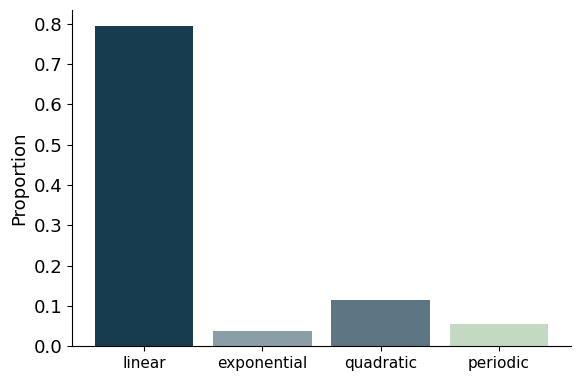

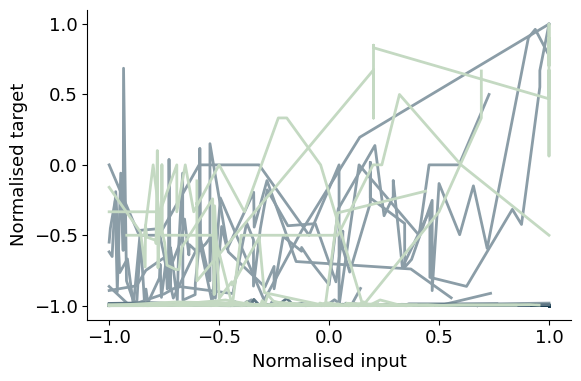

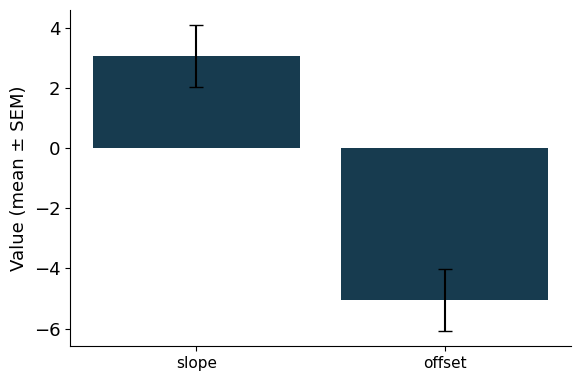

In [11]:
import seaborn as sns
# Settings
FONTSIZE=13
plt.rcParams.update({"font.size": FONTSIZE})
functions=["linear", "exponential", "quadratic", "periodic"]
colors=["#173b4f","#8b9da7",'#5d7684', '#c4d9c2'][:len(functions)]
model_df=pd.DataFrame(records,columns=["task_id","model","bic","p1","p2","p3"])
props=model_df["model"].value_counts(normalize=True).reindex(functions,fill_value=0)
plt.figure(figsize=(6,4))
pos=np.arange(len(functions))*0.6
plt.bar(pos,props.values,color=colors,width=0.5)
plt.xticks(pos,functions,fontsize=FONTSIZE-2); plt.ylabel("Proportion"); 
# plt.title("Proportion of best models"); 
sns.despine(); plt.grid(False); plt.tight_layout(); plt.show()

# overlay plot
plt.figure(figsize=(6,4))
n_best=10
# test=["periodic"]
for idx, model in enumerate(functions):
    top=model_df[model_df["model"]==model].nsmallest(n_best, "bic")
    if mode == 0:
        if model=='periodic':
            top = model_df[model_df["model"]==model][5:10]
        elif model == 'exponential':
            top = model_df[model_df["model"]==model].loc[model_df[model_df["model"]==model]['p2'].sort_values()[-14:-10].index.values]
            
    for tid in top["task_id"]:
        g=df[df["task_id"]==tid]
        xs=g["input"].values.astype(float); ys=g["target"].values.astype(float)
        ord=np.argsort(xs); plt.plot(xs[ord],ys[ord],color=colors[idx],lw=2)
        plt.xlabel("Normalised input"); plt.ylabel("Normalised target"); 
        
# plt.title(f"Top‑{n_best} functions per model"); 
plt.grid(False);  sns.despine(); plt.tight_layout(); plt.show()
# linear coeffs plot
if linear_coeffs:
    slopes=np.array([t[0] for t in linear_coeffs if not np.isnan(t[0])])
    offs=np.array([t[1] for t in linear_coeffs if not np.isnan(t[1])])
    means=[slopes.mean(),offs.mean()]; stds=[slopes.std(ddof=1)/np.sqrt(len(slopes)),offs.std(ddof=1)/np.sqrt(len(slopes))]
    plt.figure(figsize=(6,4))
    xp=np.arange(2)*0.6; plt.bar(xp,means,yerr=stds,width=0.5,color=colors[0],capsize=5)
    plt.xticks(xp,["slope","offset"],fontsize=FONTSIZE-2)
    plt.ylabel("Value (mean ± SEM)"); 
    # plt.title("Linear coefficients"); 
    plt.grid(False); sns.despine(); plt.tight_layout(); plt.show()

In [5]:
 datasets = torch.load('/u/ajagadish/ermi/functionlearning/data/generated_tasks/lichtenberg2017.pth')

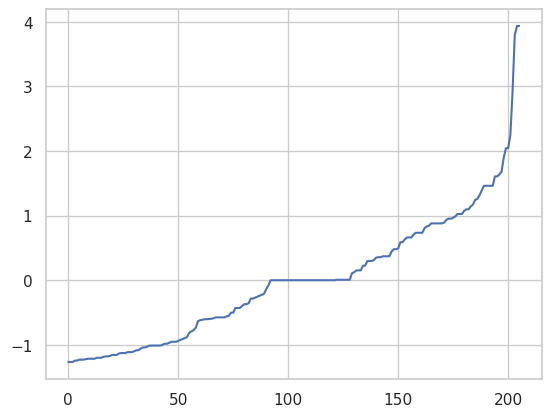

In [13]:
plt.plot(range(len(datasets[0][1])), datasets[0][1].sort()[0])

In [64]:
env_name = f'{SYS_PATH}/functionlearning/data/generated_tasks/real_data_dim1_methodbest_lichtenberg2017'
color_stats = '#173b4f'  # '#0D2C3D' #'#8b9da7'

# Load the dataset
df = pd.read_csv(f'{env_name}.csv')
# max_tasks = 750 #1000
# tasks = np.random.choice(df.task_id.unique(), max_tasks, replace=False)
# df = df[df['task_id'].isin(tasks)]
df['input'] = df['input'].apply(lambda x: eval(x)[0])
df['target'] = df['target'].apply(lambda x: eval(x)[0])
df_old = df.copy(deep=True)
# max normalize the input and target columns
# df['input'] = df.groupby('task_id')['input'].transform(lambda x: x / x.max())
# df['target'] = df.groupby('task_id')['target'].transform(lambda x: x / x.max())
df['input'] = df.groupby('task_id')['input'].transform(lambda x: x / np.abs(x).max() if x.max() != 0 else x)
df['target'] = df.groupby('task_id')['target'].transform(lambda x: x / np.abs(x).max() if x.max() != 0 else x)
df = df.sort_values(by=['task_id', 'input'])

In [65]:
mode=2
df = df.sort_values(by=['task_id', 'input'])
# if mode == 2:
#     df = df.groupby('task_id').apply(lambda x: x.sample(100)).reset_index(drop=True)
# df = df.sort_values(by=['task_id', 'input'])

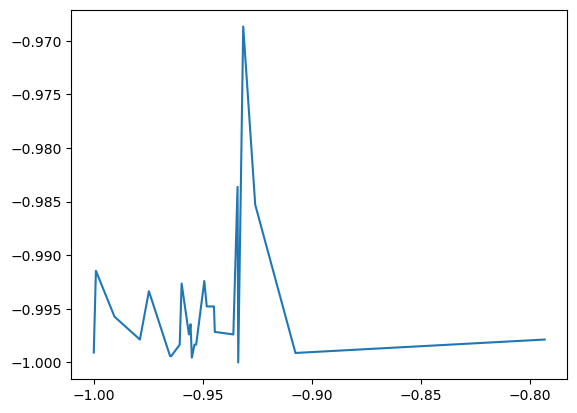

In [89]:
task_id = 1034
plt.plot(df[df.task_id==task_id].input[:25], df[df.task_id==task_id].target[:25]);

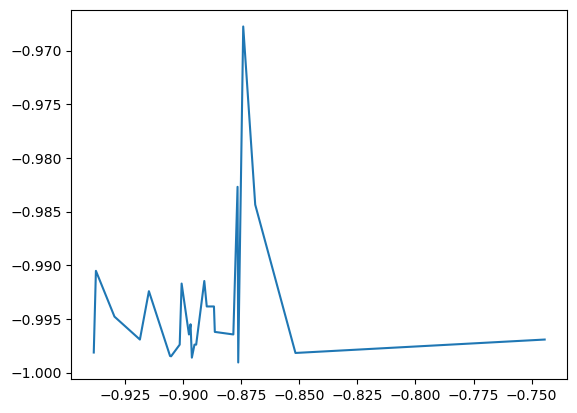

In [90]:
mode=2
df_old = df_old.sort_values(by=['task_id', 'input'])
plt.plot(df_old[df_old.task_id==task_id].input, df_old[df_old.task_id==task_id].target)